# Foul-Won-On-Possession Prediction

The goal of this notebook is to :

> Predict the probability that a player will win a foul on his possession after he receives or recovers the ball

* The goal as framed suggests we need to predict if a foul occurs on the player with the ball
* We can predict the outcome in the following ways :

  1. When a player recieves/recovers the ball, predict the outcome for that event - **First Touch**

  2. Predict the outcome by analyzing the player possession chain ("on his possession") - **Chain**

* Assuming we are modelling for the use-case of betting, **First Touch** approach fits the use-case
* We will still leverage **possession chains** in our modelling by considering past $N$ events

# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_statsbomb_pitch(ax=None, pitch_color='white', line_color='black', figsize=(12, 8), show=False):
    """
    Plots a StatsBomb-style football pitch (120x80) with Matplotlib.
    Origin: bottom-left corner.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor(pitch_color)

    # Pitch outline and center line
    plt.plot([0, 0, 120, 120, 0], [0, 80, 80, 0, 0], color=line_color)
    plt.plot([60, 60], [0, 80], color=line_color)  # Halfway line

    # Center circle and spot
    centre_circle = plt.Circle((60, 40), 9.15, color=line_color, fill=False)
    centre_spot = plt.Circle((60, 40), 0.8, color=line_color)
    ax.add_patch(centre_circle)
    ax.add_patch(centre_spot)

    # Penalty boxes and 6-yard boxes
    for x in [0, 120]:
        side = 1 if x == 0 else -1
        ax.add_patch(patches.Rectangle((x - side * 18, 30), side * 18, 20, edgecolor=line_color, facecolor='none'))
        ax.add_patch(patches.Rectangle((x - side * 6, 36), side * 6, 8, edgecolor=line_color, facecolor='none'))
        plt.plot(x - side * 11, 40, 'o', color=line_color)

        arc = patches.Arc((x - side * 11, 40), height=18.3, width=18.3, angle=0,
                          theta1=308 if x == 0 else 128, theta2=52 if x == 0 else 232, color=line_color)
        ax.add_patch(arc)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 80)
    ax.axis('off')

    if show:
        plt.show()
    else:
        return ax

# Import Data

In [3]:
match_df = pd.read_csv('epl_matches_15.csv')
match_df.head()

Unnamed: 0  match_id  match_date      kick_off  home_score  away_score  \
0           1   3754058  2016-01-02  16:00:00.000           0           0   
1           2   3754245  2015-10-17  16:00:00.000           1           0   
2           3   3754136  2015-12-19  18:30:00.000           1           1   
3           4   3754037  2016-04-30  16:00:00.000           2           1   
4           5   3754039  2016-02-13  16:00:00.000           1           2   

  match_status                last_updated  match_week  \
0    available  2021-10-29T23:44:19.940296          20   
1    available  2022-12-01T13:09:17.044015           9   
2    available  2020-11-12T23:48:19.757269          17   
3    available     2021-07-07T17:59:57.456          36   
4    available     2021-07-25T18:09:51.386          26   

   competition.competition_id  ... away_team.away_team_name  \
0                           2  ...          AFC Bournemouth   
1                           2  ...               Sunderland   
2                           2  ...              Aston Villa   
3                           2  ...          AFC Bournemouth   
4                           2  ...                  Watford   

                                  away_team.managers  competition_stage.id  \
0        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
1    561, Sam Allardyce, NA, 1954-10-19, 68, England                     1   
2         92, Rémi Garde, NA, 1966-04-03, 78, France                     1   
3        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
4  236, Enrique Sánchez Flores, Quique Sánchez Fl...                     1   

  competition_stage.name  stadium.id         stadium.name referee.id  \
0         Regular Season          20  King Power Stadium           5   
1         Regular Season          33        The Hawthorns          4   
2         Regular Season        4674     St. James'' Park          4   
3         Regular Season          12        Goodison Park          7   
4         Regular Season          37        Selhurst Park          9   

      referee.name referee.country.id referee.country.name  
0   Andre Marriner                 68              England  
1  Martin Atkinson                 68              England  
2  Martin Atkinson                 68              England  
3   Neil Swarbrick                 68              England  
4    Robert Madley                 68              England  

[5 rows x 28 columns]

In [4]:
match_df.shape

(380, 28)

In [5]:
match_df.columns

Index(['Unnamed: 0', 'match_id', 'match_date', 'kick_off', 'home_score',
       'away_score', 'match_status', 'last_updated', 'match_week',
       'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.managers', 'competition_stage.id', 'competition_stage.name',
       'stadium.id', 'stadium.name', 'referee.id', 'referee.name',
       'referee.country.id', 'referee.country.name'],
      dtype='object')

In [6]:
events_df = pd.read_csv('epl_event_data_15.csv')
events_df.head()

id  index  period     timestamp  minute  \
0  9153e9f4-f69c-4e04-8f64-505592e212cd      1       1  00:00:00.000       0   
1  3fbcf4e7-94d1-485a-be85-fd26a6af0318      2       1  00:00:00.000       0   
2  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d      3       1  00:00:00.000       0   
3  100362ee-9311-4187-bd8a-0201d9db2565      4       1  00:00:00.000       0   
4  2ca23eea-a984-47e4-8243-8f00880ad1c9      5       1  00:00:01.753       0   

   second  possession  player_possession  duration  \
0       0           1                  1  0.000000   
1       0           1                  2  0.000000   
2       0           1                  3  0.000000   
3       0           1                  4  0.000000   
4       1           2                  5  0.308263   

                         related_events  ... pass.end_location  \
0                                   NaN  ...               NaN   
1                                   NaN  ...               NaN   
2  100362ee-9311-4187-bd8a-0201d9db2565  ...               NaN   
3  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d  ...               NaN   
4  1f98c89e-2326-4200-8c12-a987fdbbaf2e  ...        60.4, 43.6   

  dribble.outcome.id dribble.outcome.name  ball_receipt.outcome.id  \
0                NaN                  NaN                      NaN   
1                NaN                  NaN                      NaN   
2                NaN                  NaN                      NaN   
3                NaN                  NaN                      NaN   
4                NaN                  NaN                      NaN   

  ball_receipt.outcome.name  carry.end_location duel.outcome.id  \
0                       NaN                 NaN             NaN   
1                       NaN                 NaN             NaN   
2                       NaN                 NaN             NaN   
3                       NaN                 NaN             NaN   
4                       NaN                 NaN             NaN   

   duel.outcome.name competition_id  match_id  
0                NaN              2   3754058  
1                NaN              2   3754058  
2                NaN              2   3754058  
3                NaN              2   3754058  
4                NaN              2   3754058  

[5 rows x 49 columns]

In [7]:
events_df.shape

(1313783, 49)

In [8]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

* We are working with the Statsbomb event-level data
* We have matches inforamtion :
    * Team context - players, managers
    * Referee context
    * Home/Away
* We have event information :
    * Time of the game
    * Lineups and formation
    * Event location
    * Possession information
    * Pass information
    * Event type information
    * Player information
* Qualifier information is also available for pass, dribble, duels

# Feature Exploration

In [9]:
# distribution of event types
events_df['type.name'].value_counts()

type.name
Pass                 368619
Ball Receipt*        340324
Carry                276949
Pressure             115402
Ball Recovery         40943
Duel                  32290
Clearance             21645
Block                 14839
Dribble               13721
Goal Keeper           11777
Miscontrol            10786
Dispossessed          10520
Shot                   9908
Foul Committed         9512
Foul Won               9112
Interception           8920
Dribbled Past          8771
Substitution           2109
Half Start             1520
Half End               1520
Injury Stoppage        1032
Starting XI             760
Tactical Shift          625
50/50                   559
Shield                  503
Referee Ball-Drop       272
Bad Behaviour           193
Error                   178
Player Off              145
Player On               144
Offside                 109
Own Goal Against         38
Own Goal For             38
Name: count, dtype: int64

In [10]:
# convert to lowercase, replace whitespace with underscore and remove the '*'
events_df['type.name'] = events_df['type.name'].str.lower().str.replace(' ', '_').str.replace('*', '').str.strip()
events_df['type.name'].value_counts()

type.name
pass                 368619
ball_receipt         340324
carry                276949
pressure             115402
ball_recovery         40943
duel                  32290
clearance             21645
block                 14839
dribble               13721
goal_keeper           11777
miscontrol            10786
dispossessed          10520
shot                   9908
foul_committed         9512
foul_won               9112
interception           8920
dribbled_past          8771
substitution           2109
half_start             1520
half_end               1520
injury_stoppage        1032
starting_xi             760
tactical_shift          625
50/50                   559
shield                  503
referee_ball-drop       272
bad_behaviour           193
error                   178
player_off              145
player_on               144
offside                 109
own_goal_against         38
own_goal_for             38
Name: count, dtype: int64

In [11]:
# exclude events to reduce noise
event_exclusions = [
    'error', 'starting_xi', 'half_start', 'half_end'
]

events_df = events_df[~events_df['type.name'].isin(event_exclusions)]
events_df.shape

(1309805, 49)

In [12]:
events_df[["location_x", "location_y"]] = events_df["location"].str.split(",", expand=True).astype(float)

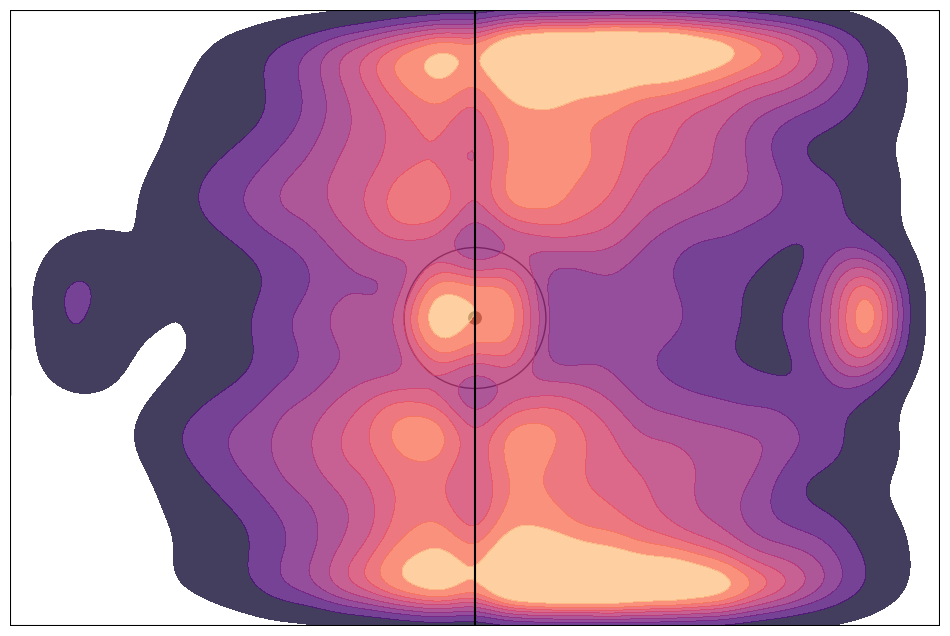

In [15]:
# Plot location heatmap of ball reciept events
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df['type.name']=='ball_receipt']
    , x="location_x"
    , y="location_y"
    , cmap="magma"
    , fill=True
    , thresh=0.05
    , alpha=0.8
    , ax=ax
)
plt.show()

* As expected we see higher ball recieves in the central midfield and wings
* Some recieves in the final third as the ball is played into forwards

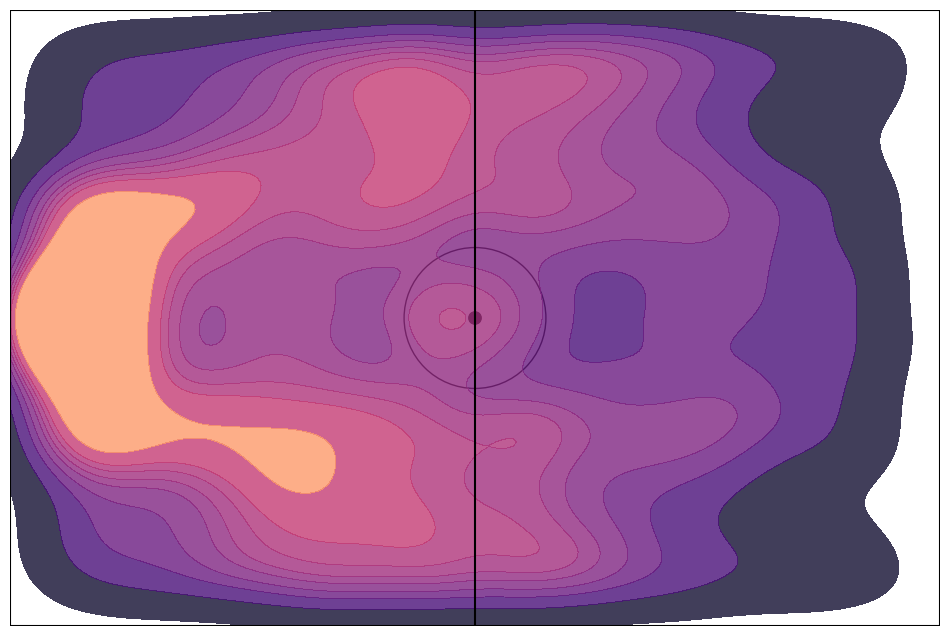

In [16]:
# Plot location heatmap of ball recovery events
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df['type.name']=='ball_recovery']
    , x="location_x"
    , y="location_y"
    , cmap="magma"
    , fill=True
    , thresh=0.05
    , alpha=0.8
    , ax=ax
)
plt.show()

* High density for ball recoveries near the penalty area - last ditch tackles, defenders dominate, opposition playing risky forward passes
* Sparse recoveries upfront by the forwards

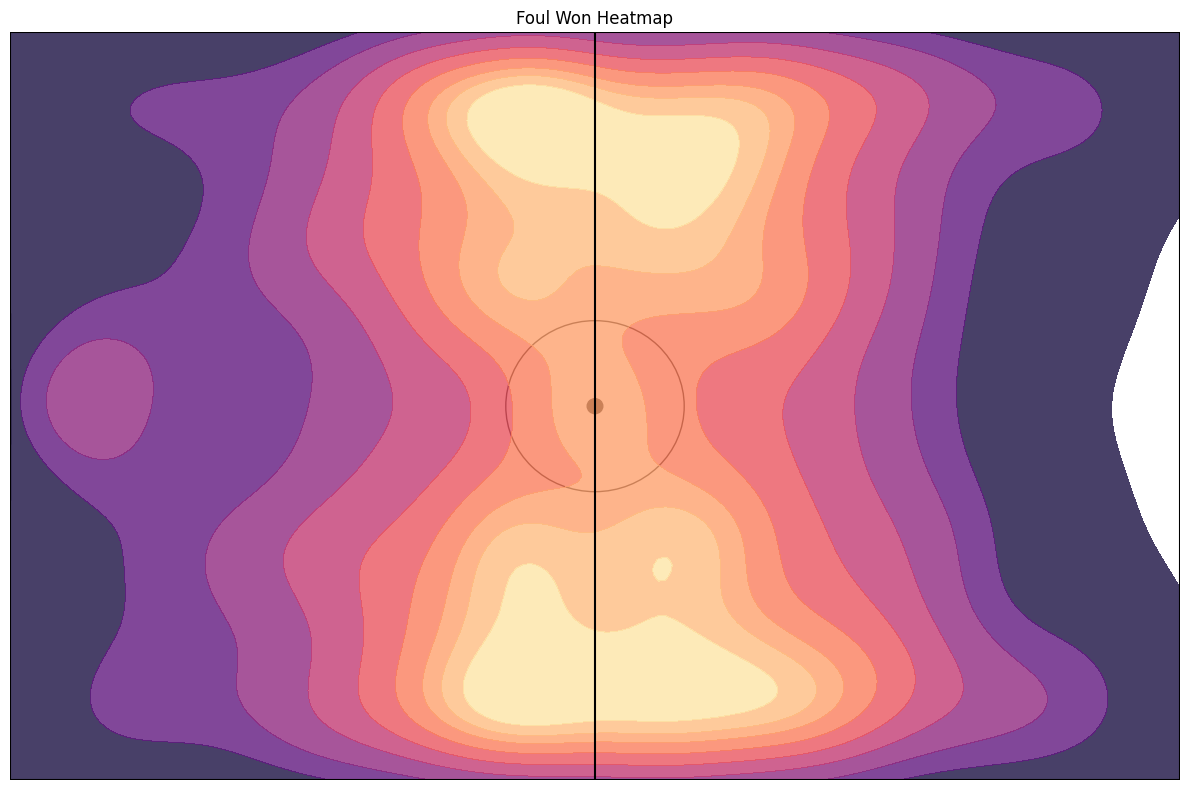

In [21]:
ax = plot_statsbomb_pitch()
sns.kdeplot(
    data=events_df[events_df["type.name"] == "foul_won"]
    , x="location_x"
    , y="location_y"
    , fill=True
    , cmap="magma"
    , thresh=0.01
    , alpha=0.8
    , ax=ax
)
plt.title("Foul Won Heatmap")
plt.tight_layout()
plt.show()

* High density of fouls won in the midfield and wings
* Fouls are less common where players are playing safer

**Feature Engineering Ideas**

* Assign zones - defensive third, wide channels, voronoi zones
* Zone level foul probability map - $P(foul\_won|E(Zone)), \text{where }E(Zone) \text{ is the zone for the ball reciept or recovery event}$

In [51]:
# events preceeding a player receiving/recovering the ball and winning a foul

# gathering the events in the player possession chain and generating our target variable - is_foul_won (during a player possession)
start_events = events_df[events_df["type.name"].isin(['ball_recovery', 'ball_receipt'])]
start_events = start_events.groupby(["match_id","possession","player_possession"]).size().reset_index(name="n_events")

In [52]:
start_events.n_events.describe()

count    379091.00000
mean          1.00574
std           0.07558
min           1.00000
25%           1.00000
50%           1.00000
75%           1.00000
max           3.00000
Name: n_events, dtype: float64

* Most of the players only keep possession of the ball for 1 or 2 events

In [53]:
player_possession_chains = []
for i, row in start_events.iterrows():
    match_id = row['match_id']
    possession_id = row['possession']
    player_id = row['player_possession']
    player_possession_chain = events_df[
        (events_df['match_id'] == match_id)
        & (events_df["possession"] == possession_id)
        & (events_df["player_possession"] == player_id)
    ].copy()
    event_sequence = player_possession_chain["type.name"].tolist()
    unique_events = list(set(event_sequence))
    num_events = len(event_sequence)
    is_foul_won = 1 if "foul_won" in event_sequence else 0
    player_possession_chains.append(
        {
            'match_id':match_id
            , 'possession_id':possession_id
            , 'player_id':player_id
            , 'n_events':num_events
            , 'event_sequence':event_sequence
            , 'is_foul_won':is_foul_won
        }
    )

In [54]:
player_possession_chains_df = pd.DataFrame(player_possession_chains)
player_possession_chains_df.head()

match_id  possession_id  player_id  n_events  \
0   3753972              2          6         3   
1   3753972              2          7         3   
2   3753972              2          8         3   
3   3753972              2          9         3   
4   3753972              2         10         3   

                   event_sequence  is_foul_won  
0  [ball_receipt, pass, pressure]            0  
1     [ball_receipt, carry, pass]            0  
2     [ball_receipt, carry, pass]            0  
3     [ball_receipt, carry, pass]            0  
4     [ball_receipt, carry, pass]            0

In [55]:
player_possession_chains_df.is_foul_won.value_counts()

is_foul_won
0    376203
1      2888
Name: count, dtype: int64

In [56]:
player_possession_chains_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992382
1    0.007618
Name: proportion, dtype: float64

* Winning a foul after recieving/recovering the ball is a very rare event.
* We will likely downsample class 0 events to tackle class imbalance.

In [58]:
# build a pre-context dataframe containing the 4 events preceeding ball receipt/recovery for is_foul_won=1 events
pre_contexts = []
N = 4
foul_won_chains = player_possession_chains_df[player_possession_chains_df.is_foul_won==1]

for i, chain in foul_won_chains.iterrows():
    match_id = chain["match_id"]
    player_id = chain["player_id"]
    possession_id = chain["possession_id"]
    # start event index
    start_event_idx = events_df[
        (events_df["match_id"] == match_id) &
        (events_df["possession"] == possession_id) &
        (events_df["player_possession"] == player_id)
    ].sort_values(by="index").index[0]

    context = events_df.loc[start_event_idx - N : start_event_idx]
    pre_contexts.append(context)

In [35]:
pd.set_option('display.max_columns', None)
pre_contexts[0]

id  index  period     timestamp  \
88474  372566d6-a4f7-4ca9-8983-6a6555bd8265    281       1  00:07:03.758   
88475  135b9bab-3778-492a-b697-590d1bc4634b    282       1  00:07:03.882   
88476  5974a569-0e0d-4c7b-baab-f40e629d082b    283       1  00:07:04.989   
88477  82b1a2cd-fd6f-4739-bb7c-3f436227b544    284       1  00:07:06.757   
88478  8263c681-694c-4e04-a489-2ccd47800aa2    285       1  00:07:07.078   

       minute  second  possession  player_possession  duration  \
88474       7       3          19                127  1.230284   
88475       7       3          19                127  1.154043   
88476       7       4          19                127  2.089125   
88477       7       6          19                127  0.858198   
88478       7       7          19                128       NaN   

                                          related_events    location  \
88474  135b9bab-3778-492a-b697-590d1bc4634b, 24f45877...  33.2, 74.6   
88475  372566d6-a4f7-4ca9-8983-6a6555bd8265, 5974a569...   86.1, 7.9   
88476  135b9bab-3778-492a-b697-590d1bc4634b, 8263c681...  36.2, 74.6   
88477  1ef4cec1-4461-4d1d-95a6-f069de9bcb66, 8263c681...  47.3, 18.7   
88478  5974a569-0e0d-4c7b-baab-f40e629d082b, 82b1a2cd...    71, 61.7   

      under_pressure counterpress  type.id     type.name  possession_team.id  \
88474           True          NaN       43         carry                  26   
88475            NaN          NaN       17      pressure                  26   
88476           True          NaN       30          pass                  26   
88477            NaN          NaN       17      pressure                  26   
88478           True          NaN       42  ball_receipt                  26   

      possession_team.name  play_pattern.id play_pattern.name  team.id  \
88474         Swansea City                4     From Throw In       26   
88475         Swansea City                4     From Throw In       28   
88476         Swansea City                4     From Throw In       26   
88477         Swansea City                4     From Throw In       28   
88478         Swansea City                4     From Throw In       26   

             team.name  tactics.formation tactics.lineup  player.id  \
88474     Swansea City                NaN            NaN     4726.0   
88475  AFC Bournemouth                NaN            NaN     3346.0   
88476     Swansea City                NaN            NaN     4726.0   
88477  AFC Bournemouth                NaN            NaN    40218.0   
88478     Swansea City                NaN            NaN    15996.0   

                         player.name  position.id      position.name  \
88474                   Kyle Bartley          3.0  Right Center Back   
88475                    Joshua King         23.0     Center Forward   
88476                   Kyle Bartley          3.0  Right Center Back   
88477                 Sylvain Distin          5.0   Left Center Back   
88478  Éderzito António Macedo Lopes         23.0     Center Forward   

       pass.length  pass.angle  pass.height.id pass.height.name  \
88474          NaN         NaN             NaN              NaN   
88475          NaN         NaN             NaN              NaN   
88476    37.114014   -0.354986             3.0        High Pass   
88477          NaN         NaN             NaN              NaN   
88478          NaN         NaN             NaN              NaN   

       pass.body_part.id pass.body_part.name  pass.type.id pass.type.name  \
88474                NaN                 NaN           NaN            NaN   
88475                NaN                 NaN           NaN            NaN   
88476               40.0          Right Foot           NaN            NaN   
88477                NaN                 NaN           NaN            NaN   
88478                NaN                 NaN           NaN            NaN   

       pass.outcome.id pass.outcome.name  pass.receipient.id  \
88474              NaN               N

In [62]:
# build event sequences from pre-context events

pre_context_list = []
for pre_context in pre_contexts:
    # pre_context is a dataframe of the last 4 events before the ball receipt/recovery event with the 5th event being the receipt/recovery event
    event_sequence = pre_context['type.name'].tolist()[:-1]
    event_id = pre_context.iloc[-1,:]['index']
    match_id = pre_context.iloc[-1,:]['match_id']
    possession_id = pre_context.iloc[-1,:]['possession']
    player_id = pre_context.iloc[-1,:]['player_possession']
    pre_context_list.append(
        {
            'match_id':match_id
            , 'possession_id':possession_id
            , 'player_id':player_id
            , 'event_sequence':event_sequence
        }
    )

In [63]:
pre_context_df = pd.DataFrame(pre_context_list)
pre_context_df.head()

match_id  possession_id  player_id  \
0   3753972             46        408   
1   3753972             62        550   
2   3753972             70        622   
3   3753972            104        892   
4   3753972            145       1255   

                                event_sequence  
0    [ball_recovery, pressure, pass, pressure]  
1      [carry, miscontrol, pressure, pressure]  
2  [ball_receipt, carry, pressure, miscontrol]  
3   [foul_won, pressure, miscontrol, pressure]  
4        [ball_receipt, carry, pass, pressure]

In [64]:
pre_context_df.event_sequence.values[0]

['ball_recovery', 'pressure', 'pass', 'pressure']

In [66]:
pre_context_df['event_sequence_string'] = pre_context_df['event_sequence'].apply(lambda x: " ".join(x))

In [70]:
# top 10 sequences (by frequency) before a player receives/recovers a ball and wins a foul
pre_context_df['event_sequence_string'].value_counts().sort_values(ascending=False).head(10)

event_sequence_string
ball_receipt carry pass pressure          642
pass ball_receipt pass pressure           266
carry pressure pass pressure              192
ball_recovery carry pass pressure         124
pass ball_receipt carry pass              121
ball_receipt carry miscontrol pressure     59
carry pass ball_receipt pass               40
ball_receipt carry pressure pass           40
carry pass pressure ball_receipt           39
pressure ball_receipt pass pressure        38
Name: count, dtype: int64

These are high-frequency build ups which often end up in a foul won scenario

* ball_receipt carry pass pressure - a common structured buildup ending in pressure by the opponent
* pass ball_receipt pass pressure - quick passing inviting opponents to step up and pressure
* carry pressure pass pressure - repeated pressure by the opponent, reducing passing options
* ball_receipt carry miscontrol pressure - miscontrol by the player inviting pressure from the opponent

In [72]:
# rare sequences before a player receives/recovers a ball and wins a foul
pre_context_df['event_sequence_string'].value_counts().sort_values().head(15)

event_sequence_string
pass pressure ball_receipt carry              1
ball_receipt carry foul_committed foul_won    1
carry pass ball_receipt clearance             1
pressure duel clearance pressure              1
substitution tactical_shift pass pass         1
pressure shield ball_receipt pass             1
block interception pass interception          1
ball_recovery carry pass block                1
duel substitution pass pressure               1
ball_receipt clearance substitution pass      1
carry pass ball_receipt interception          1
shot goal_keeper ball_recovery pass           1
ball_receipt duel pass pass                   1
miscontrol pressure ball_recovery pressure    1
block miscontrol pass pressure                1
Name: count, dtype: int64

These are rare but semantically rich build up sequences representing pressure overloads, player mistakes, transition breakdowns which lead to a foul won scenario

* pass pressure ball_receipt carry - passing under pressure scenarios
* ball_receipt carry foul_committed foul_won - interesting buildup, might have to address with labelling logic
* pressure duel clearance pressure - high pressure-intense scenario
* substitution tactical_shift pass pass - strategy changes by manager
* block interception pass interception - opposition trying at close down on players
* shot goal_keeper ball_recovery pass - shot saved by goalkeeper, leading to a counter-attack scenario

In [76]:
# compute the same for all player possession chains
pre_contexts = []
N = 4
for i, chain in player_possession_chains_df.iterrows():
    match_id = chain["match_id"]
    player_id = chain["player_id"]
    possession_id = chain["possession_id"]
    # start event index
    start_event_idx = events_df[
        (events_df["match_id"] == match_id) &
        (events_df["possession"] == possession_id) &
        (events_df["player_possession"] == player_id)
    ].sort_values(by="index").index[0]

    context = events_df.loc[start_event_idx - N : start_event_idx]
    event_sequence = context['type.name'].tolist()[:-1]
    event_id = context.iloc[-1,:]['index']
    match_id = context.iloc[-1,:]['match_id']
    possession_id = context.iloc[-1,:]['possession']
    player_id = context.iloc[-1,:]['player_possession']
    pre_contexts.append(
        {
            'match_id':match_id
            , 'possession_id':possession_id
            , 'player_id':player_id
            , 'event_sequence':event_sequence
            , 'is_foul_won': chain['is_foul_won']
        }
    )

In [77]:
pre_context_df = pd.DataFrame(pre_contexts)
pre_context_df.head()

match_id  possession_id  player_id                         event_sequence  \
0   3753972              2          6                                 [pass]   
1   3753972              2          7   [pass, ball_receipt, pass, pressure]   
2   3753972              2          8  [pressure, ball_receipt, carry, pass]   
3   3753972              2          9      [pass, ball_receipt, carry, pass]   
4   3753972              2         10      [pass, ball_receipt, carry, pass]   

   is_foul_won  
0            0  
1            0  
2            0  
3            0  
4            0

In [111]:
# compute lift to identify dominant patterns for foul won events
pre_context_df['event_sequence_string'] = pre_context_df['event_sequence'].apply(lambda x: " ".join(x))
n_class1_events = (pre_context_df['is_foul_won'] == 1).sum()
n_class0_events = (pre_context_df['is_foul_won'] == 0).sum()

class1_counts = (
    pre_context_df[pre_context_df['is_foul_won'] == 1]['event_sequence_string']
    .value_counts()
    .rename('class1_counts')
)

class0_counts = (
    pre_context_df[pre_context_df['is_foul_won'] == 0]['event_sequence_string']
    .value_counts()
    .rename('class0_counts')
)

lift_df = pd.concat([class1_counts, class0_counts], axis=1).fillna(0)
lift_df['p_class1'] = lift_df['class1_counts']/n_class1_events
lift_df['p_class0'] = lift_df['class0_counts']/n_class0_events

# drop sequences with only 1 counts
lift_df = lift_df[(lift_df['class1_counts'] > 1) & (lift_df['class0_counts'] > 1)]
lift_df["lift"] = lift_df["p_class1"] / (lift_df["p_class0"])

lift_df.head()

class1_counts  class0_counts  p_class1  \
event_sequence_string                                                       
ball_receipt carry pass pressure           642.0        11555.0  0.222299   
pass ball_receipt pass pressure            266.0         4733.0  0.092105   
carry pressure pass pressure               192.0         3667.0  0.066482   
ball_recovery carry pass pressure          124.0         1521.0  0.042936   
pass ball_receipt carry pass               121.0       134974.0  0.041898   

                                   p_class0       lift  
event_sequence_string                                   
ball_receipt carry pass pressure   0.030715   7.237526  
pass ball_receipt pass pressure    0.012581   7.320996  
carry pressure pass pressure       0.009747   6.820487  
ball_recovery carry pass pressure  0.004043  10.619829  
pass ball_receipt carry pass       0.358780   0.116778

In [112]:
sorted_lift_df = lift_df.sort_values("lift", ascending=False)
sorted_lift_df.head()

class1_counts  \
event_sequence_string                                              
ball_receipt miscontrol pressure pressure                    3.0   
clearance block clearance pressure                           2.0   
dribble duel block pressure                                  2.0   
block goal_keeper block pressure                             2.0   
ball_receipt injury_stoppage injury_stoppage pass            2.0   

                                                   class0_counts  p_class1  \
event_sequence_string                                                        
ball_receipt miscontrol pressure pressure                    3.0  0.001039   
clearance block clearance pressure                           3.0  0.000693   
dribble duel block pressure                                  4.0  0.000693   
block goal_keeper block pressure                             4.0  0.000693   
ball_receipt injury_stoppage injury_stoppage pass            4.0  0.000693   

                                                   p_class0        lift  
event_sequence_string                                                    
ball_receipt miscontrol pressure pressure          0.000008  130.264197  
clearance block clearance pressure                 0.000008   86.842798  
dribble duel block pressure                        0.000011   65.132098  
block goal_keeper block pressure                   0.000011   65.132098  
ball_receipt injury_stoppage injury_stoppage pass  0.000011   65.132098

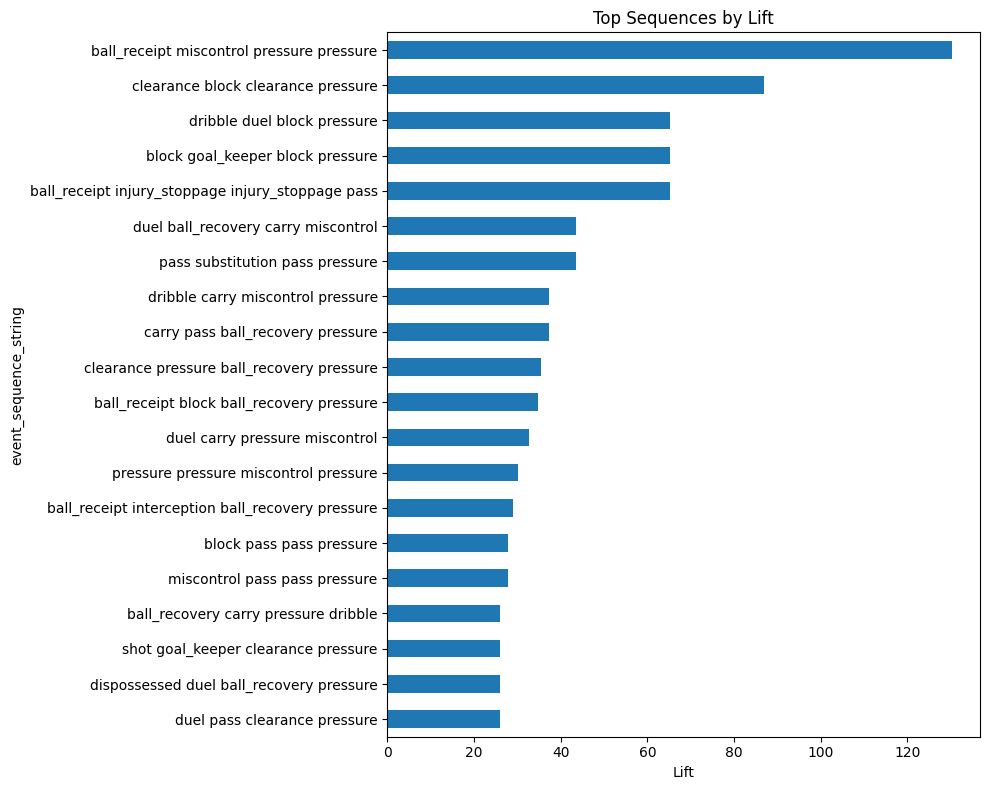

In [113]:
sorted_lift_df.head(20)["lift"].plot(kind="barh", figsize=(10, 8), title="Top Sequences by Lift")
plt.xlabel("Lift")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Save context df to disk

In [114]:
pre_context_df.to_csv("context_events.csv")

# Markov Modelling of Event States

**What's the probability of player winning a foul, given the event transitions that occurred before they got the ball ?**

In [120]:
from collections import defaultdict

def extract_transitions(sequences):
    transitions = defaultdict(lambda: defaultdict(int))
    for sequence in sequences:
        for a,b in zip(sequence[:-1], sequence[1:]):
            transitions[a][b] += 1
    # normalize to get probability
    probs = defaultdict(lambda: defaultdict(int))
    for a in transitions:
        total = sum(transitions[a].values())
        for b in transitions:
            probs[a][b] = transitions[a][b]/total
    return transitions, probs

In [123]:
class1_sequences = pre_context_df[pre_context_df["is_foul_won"] == 1]["event_sequence"]
class0_sequences = pre_context_df[pre_context_df["is_foul_won"] == 0]["event_sequence"]

class1_transitions, class1_probs = extract_transitions(class1_sequences)
class0_transitions, class0_probs = extract_transitions(class0_sequences)

class1_transition_df = pd.DataFrame(class1_transitions)
class0_transition_df = pd.DataFrame(class0_transitions)

In [125]:
class1_transition_df

ball_recovery  pressure  pass  carry  miscontrol  \
pressure                    52        71  1779    305         119   
carry                      173         0     0      0           0   
pass                        22       360    88   1165          37   
clearance                    2        15    27      0           4   
duel                         2         1    25      0           1   
ball_recovery                3        17    16      1          11   
block                        1         0    44      0           1   
miscontrol                   0        39     0    109           0   
ball_receipt                 0       166   669      0           0   
foul_won                     0         0     0      0           0   
dispossessed                 0        56     0     37           0   
dribble                      0        28     0     17           0   
interception                 0         0     7      1           0   
goal_keeper                  0         2     2      0           0   
shot                         0         9     0     13           0   
dribbled_past                0        10     0      6           0   
injury_stoppage              0         0     0      0           0   
foul_committed               0        12     2      8           1   
substitution                 0         0     2      0           0   
player_off                   0         0     0      0           0   
tactical_shift               0         0     0      0           0   
shield                       0         1     3      0           0   
player_on                    0         0     0      1           0   
50/50                        0         0     0      0           1   
bad_behaviour                0         0     0      0           0   

                 ball_receipt  foul_won  dispossessed  duel  dribble  \
pressure                   12         1             0   113       15   
carry                     948         3             0    32       36   
pass                      499        31             0   135        1   
clearance                  61         0             0    50        2   
duel                       72         0           124     0       61   
ball_recovery              14         0             0    13        0   
block                      45         0             0     4        0   
miscontrol                 24         0             0     5        0   
ball_receipt                0         0             0    10        0   
foul_won                    0         0             0     0        0   
dispossessed                0         0             0     0        0   
dribble                     0         0             0     0        0   
interception               74         0             0     0        0   
goal_keeper                 6         0             1     0        0   
shot                        9         1             0     3        0   
dribbled_past               1         0             0     0        0   
injury_stoppage             2         0             0     0        0   
foul_committed              1         0             0     1        0   
substitution                2         2             0     2        0   
player_off                  0         0             0     1        0   
tactical_shift              0         0             0     0        0   
shield                      0         0             0     0        0   
player_on                   0         0             0     0        0   
50/50                       0         0             0     0        0   
bad_behaviour               1         0             0     0        0   

                 interception  block  goal_keeper  shot  clearance  \
pressure                   50     56           14     1         89   
carry                      20      0            4     0          0   
pass                       25     47           64     0         81   
clearance                   1      5            5     0          3   

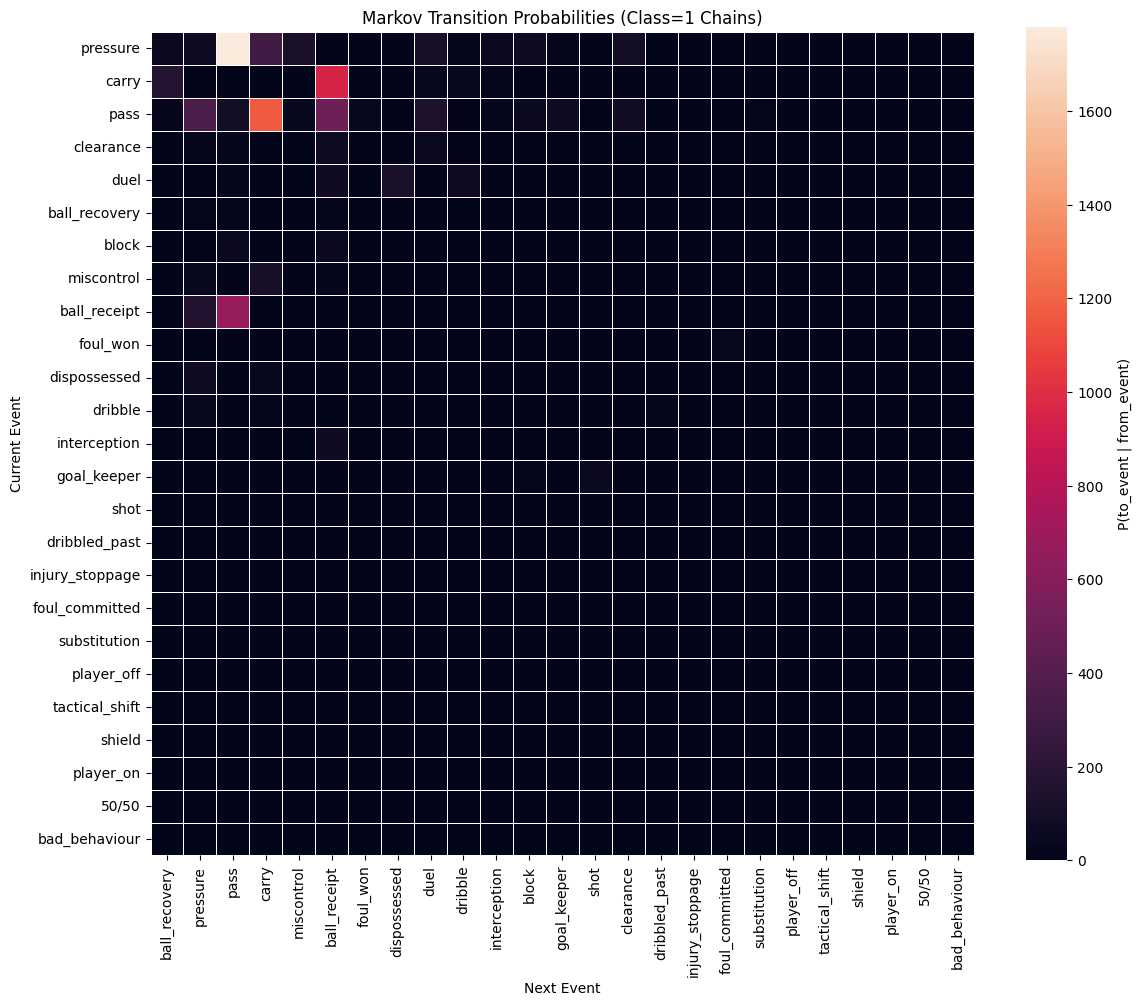

In [127]:
plt.figure(figsize=(12, 10))
sns.heatmap(class1_transition_df, cmap="rocket", linewidths=0.5, square=True, cbar_kws={'label': 'P(to_event | from_event)'})
plt.title("Markov Transition Probabilities (Class=1 Chains)")
plt.xlabel("Next Event")
plt.ylabel("Current Event")
plt.tight_layout()
plt.show()

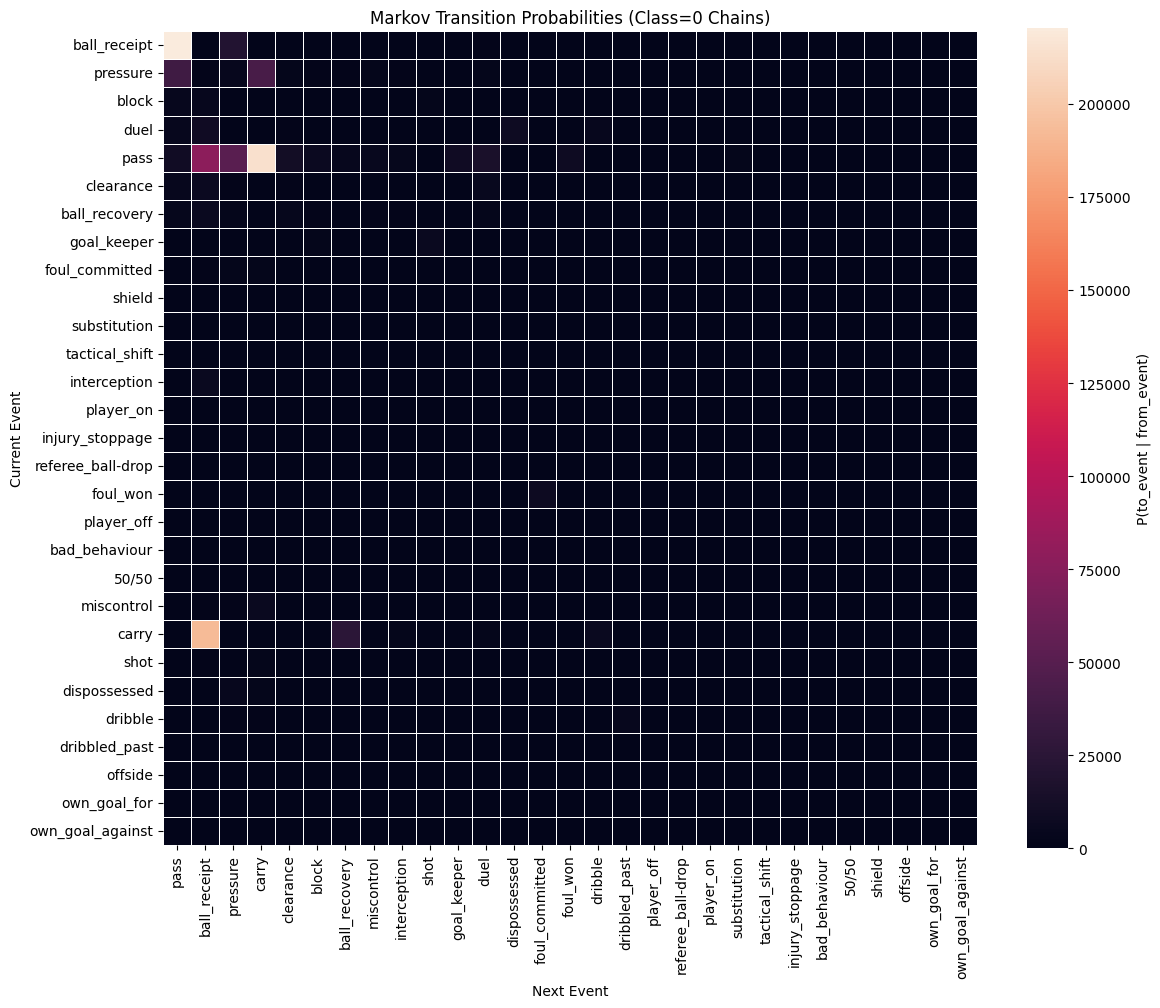

In [128]:
plt.figure(figsize=(12, 10))
sns.heatmap(class0_transition_df, cmap="rocket", linewidths=0.5, square=True, cbar_kws={'label': 'P(to_event | from_event)'})
plt.title("Markov Transition Probabilities (Class=0 Chains)")
plt.xlabel("Next Event")
plt.ylabel("Current Event")
plt.tight_layout()
plt.show()

In [134]:
# compute lift

lift = defaultdict(lambda : defaultdict(float))

for curr_event in class1_probs:
    for next_event in class1_probs[curr_event]:
        p_class1 = class1_probs[curr_event][next_event]
        p_class0 = class0_probs[curr_event][next_event]
        lift[curr_event][next_event] = p_class1/(p_class0 if p_class0 > 0 else 1)

In [135]:
lift_df = pd.DataFrame(lift)
lift_df.head()

ball_recovery  pressure      pass     carry  miscontrol  \
ball_recovery       0.945603  0.860532  0.504442  1.308265    0.408335   
pressure            6.074019  2.250486  5.139957  1.187363    2.610553   
pass                0.711788  0.800899  0.926634  0.881982    0.452884   
carry               0.843670  0.000000  0.000000  0.000000    0.000000   
miscontrol          0.000000  2.697261  0.000000  3.140766    0.000000   

               ball_receipt  foul_won  dispossessed      duel   dribble  \
ball_recovery      0.449388  0.000000           0.0  0.473528  0.000000   
pressure           1.850900  6.553981           0.0  4.367033  4.826589   
pass               1.112045  0.984685           0.0  0.704477  0.315701   
carry              0.854130  0.957323           0.0  1.033088  0.576861   
miscontrol         2.605399  0.000000           0.0  0.844615  0.000000   

               interception     block  goal_keeper       shot  clearance  \
ball_recovery      0.377097  0.503643     0.515329   0.000000   0.301497   
pressure           3.687261  3.238073     3.657706  11.119444   3.744363   
pass               0.642596  0.705013     0.934433   0.000000   0.713586   
carry              0.559061  0.000000     0.688914   0.000000   0.000000   
miscontrol         4.286738  2.521714     0.000000   0.000000   0.000000   

               dribbled_past  injury_stoppage  foul_committed  substitution  \
ball_recovery            0.0         0.000000             0.0      0.000000   
pressure                 0.0         0.000000             0.0      0.000000   
pass                     0.0         1.377069             0.0      1.015077   
carry                    0.0         0.000000             0.0      0.000000   
miscontrol               0.0         0.000000             0.0      0.000000   

               player_off  tactical_shift  shield  player_on  50/50  \
ball_recovery    0.000000         0.00000   0.000   0.000000   0.00   
pressure         0.000000         0.00000   0.000   0.000000   0.00   
pass             1.202899         1.17496   0.725   1.617978   2.65   
carry            0.000000         0.00000   0.000   0.000000   0.00   
miscontrol       0.000000         0.00000   0.000   0.000000   0.00   

               bad_behaviour  
ball_recovery       0.000000  
pressure            0.000000  
pass                1.260606  
carry               0.000000  
miscontrol          0.000000

In [133]:
lift_df.describe()

ball_recovery   pressure       pass      carry  miscontrol  \
count      25.000000  25.000000  25.000000  25.000000   25.000000   
mean        0.740685   0.971376   0.655594   0.924437    0.305603   
std         1.602720   1.181113   1.159985   1.372787    0.646720   
min         0.000000   0.000000   0.000000   0.000000    0.000000   
25%         0.000000   0.000000   0.000000   0.000000    0.000000   
50%         0.000000   0.561320   0.000000   0.000000    0.000000   
75%         0.711782   1.733552   0.744649   1.226470    0.364962   
max         6.073838   3.775227   5.139918   4.472729    2.610543   

       ball_receipt   foul_won  dispossessed         duel    dribble  \
count     25.000000  25.000000     25.000000    25.000000  25.000000   
mean       2.815401   0.455379      0.473520   108.940276   0.422819   
std        6.111011   1.357884      2.169870   541.893905   1.177401   
min        0.000000   0.000000      0.000000     0.000000   0.000000   
25%        0.000000   0.000000      0.000000     0.000000   0.000000   
50%        0.968349   0.000000      0.000000     0.000000   0.000000   
75%        1.850394   0.000000      0.000000     0.858336   0.000000   
max       27.487974   6.552349     10.845278  2710.027100   4.826410   

       interception      block  goal_keeper       shot  clearance  \
count     25.000000  25.000000    25.000000  25.000000  25.000000   
mean       0.577970   0.981479     0.427399   0.513126   0.602662   
std        1.196431   2.012108     0.848587   2.222078   1.174701   
min        0.000000   0.000000     0.000000   0.000000   0.000000   
25%        0.000000   0.000000     0.000000   0.000000   0.000000   
50%        0.000000   0.000000     0.000000   0.000000   0.000000   
75%        0.559060   0.872793     0.515321   0.000000   0.713585   
max        4.285746   8.243221     3.657616  11.112031   4.256995   

       dribbled_past  injury_stoppage  foul_committed  substitution  \
count      25.000000        25.000000       25.000000     25.000000   
mean        0.040000         0.122619        0.042712      0.131844   
std         0.200000         0.426767        0.213560      0.491547   
min         0.000000         0.000000        0.000000      0.000000   
25%         0.000000         0.000000        0.000000      0.000000   
50%         0.000000         0.000000        0.000000      0.000000   
75%         0.000000         0.000000        0.000000      0.000000   
max         0.999999         1.688398        1.067800      2.281016   

       player_off  tactical_shift     shield  player_on      50/50  \
count   25.000000       25.000000  25.000000  25.000000  25.000000   
mean     0.048116        0.046998   0.097835   0.064719   0.146769   
std      0.240579        0.234992   0.367862   0.323595   0.559863   
min      0.000000        0.000000   0.000000   0.000000   0.000000   
25%      0.000000        0.000000   0.000000   0.000000   0.000000   
50%      0.000000        0.000000   0.000000   0.000000   0.000000   
75%      0.000000        0.000000   0.000000   0.000000   0.000000   
max      1.202897        1.174958   1.720874   1.617975   2.649986   

       bad_behaviour  
count      25.000000  
mean        0.050424  
std         0.252121  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.260604

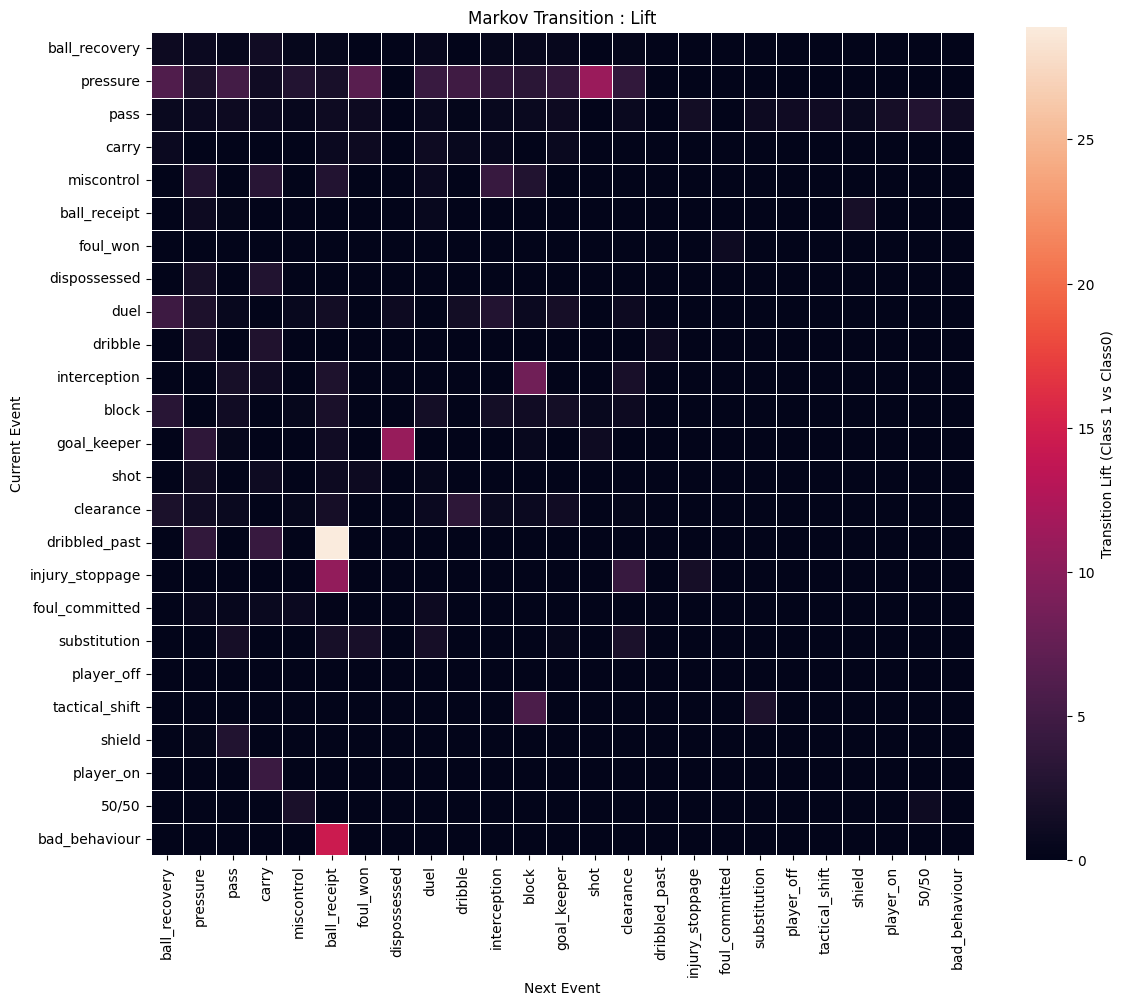

In [136]:
plt.figure(figsize=(12, 10))
sns.heatmap(lift_df, cmap="rocket", linewidths=0.5, square=True, cbar_kws={'label': 'Transition Lift (Class 1 vs Class0)'})
plt.title("Markov Transition : Lift")
plt.xlabel("Next Event")
plt.ylabel("Current Event")
plt.tight_layout()
plt.show()

* Lift heatmap highlights `miscontrol->ball_receipt, pressure->carry, goal_keeper->ball_receipt` transition states, suggesting these patterns lead to fouls
* We can score each sequence leading upto the ball receipt/recovery based on the transition likelihood :
    * $ score\_sequence = \sum_{i=1}^{N-1} log(Lift(e_i -> e_{i+1}))$

# Optimizing for $N$

We need to pick a suitable value for $N$ to find a balance between pattern strength and noise

In [143]:
def get_preceeding_N_events(events_df, possession_chain_df, N):
    pre_contexts = []
    for i, chain in possession_chain_df.iterrows():
        match_id = chain["match_id"]
        player_id = chain["player_id"]
        possession_id = chain["possession_id"]
        # start event index
        start_event_idx = events_df[
            (events_df["match_id"] == match_id) &
            (events_df["possession"] == possession_id) &
            (events_df["player_possession"] == player_id)
        ].sort_values(by="index").index[0]
    
        context = events_df.loc[start_event_idx - N : start_event_idx-1]
        event_sequence = context['type.name'].tolist()
        event_id = context['index'].iloc[0]
        match_id = context['match_id'].iloc[0]
        possession_id = context['possession'].iloc[0]
        player_id = context['player_possession'].iloc[0]
        pre_contexts.append(
            {
                'match_id':match_id
                , 'possession_id':possession_id
                , 'player_id':player_id
                , 'event_sequence':event_sequence
                , 'is_foul_won': chain['is_foul_won']
            }
        )
    return pd.DataFrame(pre_contexts)

In [180]:
# sampling player possessions chains for faster execution
sampled_chains_df = player_possession_chains_df.sample(10000)
sampled_chains_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.9936
1    0.0064
Name: proportion, dtype: float64

In [181]:
max_N = 7
model_df = get_preceeding_N_events(events_df, sampled_chains_df, max_N)

In [182]:
model_df.head()

match_id  possession_id  player_id  \
0   3754012            123       1161   
1   3754309            143       1103   
2   3754064            181       1410   
3   3754111             63        566   
4   3754218             69        449   

                                      event_sequence  is_foul_won  
0  [ball_receipt, carry, pass, pressure, ball_rec...            0  
1  [pressure, dribble, duel, carry, pass, clearan...            0  
2  [block, ball_recovery, carry, pass, ball_recei...            0  
3  [pass, ball_receipt, carry, pass, ball_receipt...            0  
4  [pass, ball_receipt, carry, block, miscontrol,...            0

In [183]:
# using countVectorizer with n-gram, train a logistic regression model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

results = []

for N in range(2, max_N+1):
    train_df = model_df.copy()
    train_df["event_seq_str"] = model_df["event_sequence"].apply(
        lambda x: " ".join(x[-N:])
    )
    vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2)
    X = vectorizer.fit_transform(train_df["event_seq_str"])
    y = train_df["is_foul_won"]

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X,y)
    y_pred = clf.predict_proba(X)[:, 1]

    roc_auc = roc_auc_score(y, y_pred)
    pr_auc = average_precision_score(y, y_pred)

    results.append({"N": N, "ROC AUC": roc_auc, "PR AUC": pr_auc})

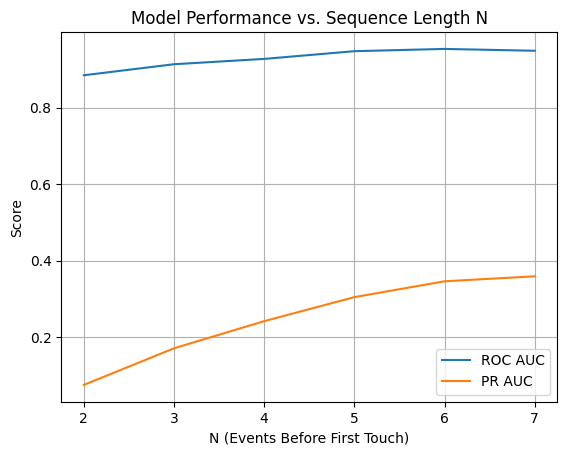

In [184]:
results_df = pd.DataFrame(results)

plt.plot(results_df["N"], results_df["ROC AUC"], label="ROC AUC")
plt.plot(results_df["N"], results_df["PR AUC"], label="PR AUC")
plt.xlabel("N (Events Before First Touch)")
plt.ylabel("Score")
plt.title("Model Performance vs. Sequence Length N")
plt.legend()
plt.grid(True)
plt.show()

In [185]:
results_df

N   ROC AUC    PR AUC
0  2  0.884947  0.074734
1  3  0.913788  0.170551
2  4  0.927745  0.241550
3  5  0.947932  0.304432
4  6  0.953863  0.345870
5  7  0.949040  0.358901

### Optimal $N = 6$

We evaluated model performance across different lengths of pre-possession event sequences (N = 2 to 6). 

- **ROC AUC** remains consistently high (0.90-0.94) across N values.
- **PR AUC** improves significantly with longer sequences, from 0.07 at N=2 to 0.34 at N=6.

We select **N = 6** as the optimal sequence window for feature extraction, balancing context depth and predictive power.

# Feature Engineering

### 1. **Pre-Event Sequence Features**
- `sequence_length`: Number of events leading up to ball receipt/recovery.
- `unique_event_count`: Count of unique event types in the sequence.
- `num_pressure_events`: Number of "pressure" events in the sequence.
- `contains_high_lift_ngram`: Binary flag for presence of top foul-prone patterns (e.g., "pass pressure").
- `starts_with_pass`, `ends_in_pressure`: Binary flags capturing structure of the buildup.
- `event_type_entropy`: Entropy of event types in the sequence (higher = more chaotic).

---

### 2. **Markov Transition Features**
- `max_transition_lift`: Highest lift among transitions in the sequence.
- `avg_transition_lift`: Mean lift across all transitions.
- `num_high_lift_transitions`: Count of transitions with lift > threshold.
- `sequence_score`: Sum of log-lift scores across all transitions.

---

### 3. **Chain-Based Features**
- `chain_length`: Number of events in player’s possession chain.
- `chain_duration`: Time from first to last event in the chain.
- `num_pass_to_dribble`: Count of pass → dribble transitions in the chain.
- `chain_ends_in_duel_or_dispossess`: Binary flag for physical loss of possession.

---

### 4. **Motion & Progression Features**
- `displacement`: Distance between first and last event of the chain.
- `directness`: Displacement divided by total path length.
- `tempo`: Events per second in the chain.
- `x_progress`: Horizontal field gain before the foul.
- `progressive_pass_rate`: Ratio of forward passes to total passes (if available).

---

### 5. **Spatial & Contextual Features**
- `start_x`, `start_y`: Ball receipt/recovery location.
- `under_pressure`: Boolean flag if player was under pressure at start.
- `zone`: Discretized zone of possession start (e.g., thirds, lanes).
- `minute`, `match_phase`: Temporal context features.

In [8]:
matches_df = pd.read_csv('epl_matches_15.csv')
matches_df.head()

Unnamed: 0  match_id  match_date      kick_off  home_score  away_score  \
0           1   3754058  2016-01-02  16:00:00.000           0           0   
1           2   3754245  2015-10-17  16:00:00.000           1           0   
2           3   3754136  2015-12-19  18:30:00.000           1           1   
3           4   3754037  2016-04-30  16:00:00.000           2           1   
4           5   3754039  2016-02-13  16:00:00.000           1           2   

  match_status                last_updated  match_week  \
0    available  2021-10-29T23:44:19.940296          20   
1    available  2022-12-01T13:09:17.044015           9   
2    available  2020-11-12T23:48:19.757269          17   
3    available     2021-07-07T17:59:57.456          36   
4    available     2021-07-25T18:09:51.386          26   

   competition.competition_id  ... away_team.away_team_name  \
0                           2  ...          AFC Bournemouth   
1                           2  ...               Sunderland   
2                           2  ...              Aston Villa   
3                           2  ...          AFC Bournemouth   
4                           2  ...                  Watford   

                                  away_team.managers  competition_stage.id  \
0        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
1    561, Sam Allardyce, NA, 1954-10-19, 68, England                     1   
2         92, Rémi Garde, NA, 1966-04-03, 78, France                     1   
3        38, Eddie Howe, NA, 1977-11-29, 68, England                     1   
4  236, Enrique Sánchez Flores, Quique Sánchez Fl...                     1   

  competition_stage.name  stadium.id         stadium.name referee.id  \
0         Regular Season          20  King Power Stadium           5   
1         Regular Season          33        The Hawthorns          4   
2         Regular Season        4674     St. James'' Park          4   
3         Regular Season          12        Goodison Park          7   
4         Regular Season          37        Selhurst Park          9   

      referee.name referee.country.id referee.country.name  
0   Andre Marriner                 68              England  
1  Martin Atkinson                 68              England  
2  Martin Atkinson                 68              England  
3   Neil Swarbrick                 68              England  
4    Robert Madley                 68              England  

[5 rows x 28 columns]

In [9]:
events_df = pd.read_csv('epl_event_data_15.csv')
events_df.head()

id  index  period     timestamp  minute  \
0  9153e9f4-f69c-4e04-8f64-505592e212cd      1       1  00:00:00.000       0   
1  3fbcf4e7-94d1-485a-be85-fd26a6af0318      2       1  00:00:00.000       0   
2  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d      3       1  00:00:00.000       0   
3  100362ee-9311-4187-bd8a-0201d9db2565      4       1  00:00:00.000       0   
4  2ca23eea-a984-47e4-8243-8f00880ad1c9      5       1  00:00:01.753       0   

   second  possession  player_possession  duration  \
0       0           1                  1  0.000000   
1       0           1                  2  0.000000   
2       0           1                  3  0.000000   
3       0           1                  4  0.000000   
4       1           2                  5  0.308263   

                         related_events  ... pass.end_location  \
0                                   NaN  ...               NaN   
1                                   NaN  ...               NaN   
2  100362ee-9311-4187-bd8a-0201d9db2565  ...               NaN   
3  06a9a4dc-d9c9-40f6-bd89-437ba7fe682d  ...               NaN   
4  1f98c89e-2326-4200-8c12-a987fdbbaf2e  ...        60.4, 43.6   

  dribble.outcome.id dribble.outcome.name  ball_receipt.outcome.id  \
0                NaN                  NaN                      NaN   
1                NaN                  NaN                      NaN   
2                NaN                  NaN                      NaN   
3                NaN                  NaN                      NaN   
4                NaN                  NaN                      NaN   

  ball_receipt.outcome.name  carry.end_location duel.outcome.id  \
0                       NaN                 NaN             NaN   
1                       NaN                 NaN             NaN   
2                       NaN                 NaN             NaN   
3                       NaN                 NaN             NaN   
4                       NaN                 NaN             NaN   

   duel.outcome.name competition_id  match_id  
0                NaN              2   3754058  
1                NaN              2   3754058  
2                NaN              2   3754058  
3                NaN              2   3754058  
4                NaN              2   3754058  

[5 rows x 49 columns]

In [5]:
events_df.columns

Index(['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession',
       'player_possession', 'duration', 'related_events', 'location',
       'under_pressure', 'counterpress', 'type.id', 'type.name',
       'possession_team.id', 'possession_team.name', 'play_pattern.id',
       'play_pattern.name', 'team.id', 'team.name', 'tactics.formation',
       'tactics.lineup', 'player.id', 'player.name', 'position.id',
       'position.name', 'pass.length', 'pass.angle', 'pass.height.id',
       'pass.height.name', 'pass.body_part.id', 'pass.body_part.name',
       'pass.type.id', 'pass.type.name', 'pass.outcome.id',
       'pass.outcome.name', 'pass.receipient.id', 'pass.recipient.name',
       'pass.end_location', 'dribble.outcome.id', 'dribble.outcome.name',
       'ball_receipt.outcome.id', 'ball_receipt.outcome.name',
       'carry.end_location', 'duel.outcome.id', 'duel.outcome.name',
       'competition_id', 'match_id'],
      dtype='object')

In [3]:
class EventMarkovModel:
    def __init__(self, sequences):
        from collections import defaultdict
        self.sequences = sequences
        self.transition_counts = defaultdict(lambda: defaultdict(int))
        self.transition_prob_matrix = defaultdict(lambda: defaultdict(int))
        self.lift_matrix = defaultdict(lambda: defaultdict(int))
    def extract_transitions(self):
        for sequence in self.sequences:
            for curr_event, next_event in zip(sequence[:-1], sequence[1:]):
                self.transition_counts[curr_event][next_event] += 1
        return self 
        
    def compute_probabilities(self):
        # normalize to get probability
        for curr_event in self.transition_counts:
            total = sum(self.transition_counts[curr_event].values())
            for next_event in self.transition_counts[curr_event]:
                self.transition_prob_matrix[curr_event][next_event] = self.transition_counts[curr_event][next_event]/total
        return self
        
    def fit(self):
        self.extract_transitions()
        self.compute_probabilities()
        
        return self
        
    def compute_lift_matrix(self, other_model, epsilon=1e-8):
        for curr_event in self.transition_prob_matrix:
            for next_event in self.transition_prob_matrix[curr_event]:
                p1 = self.transition_prob_matrix[curr_event][next_event]
                p0 = other_model.transition_prob_matrix[curr_event][next_event]
                self.lift_matrix[curr_event][next_event] = np.log((p1+epsilon)/ (p0+epsilon)) # log transformation
        return self.lift_matrix
    
    def score_sequence(self, sequence, epsilon=1e-6):
        score = 0
        for curr_event, next_event in zip(sequence[:-1], sequence[1:]):
            prob = self.transition_prob_matrix[curr_event][next_event]
            prob = max(prob, epsilon)
            score += np.log(prob)
        return score

In [4]:
def prepare_data_for_model(events_df, event_exclusions=['error', 'starting_xi', 'half_start', 'half_end']):
    events_df = events_df.copy()
    events_df['type.name'] = events_df['type.name'].str.lower().str.replace(' ', '_').str.replace('*','').str.strip()
    events_df = events_df.loc[~events_df['type.name'].isin(event_exclusions)]
    start_events = ['ball_recovery', 'ball_receipt']
    model_df = events_df[events_df["type.name"].isin(start_events)]
    model_df = model_df.groupby(['match_id','possession','player_possession']).agg(
        n_events=('index','count')
        , first_event_idx=('index','min')
    ).reset_index()
    return events_df, model_df

def generate_target_label(events_df, start_events):
    target_labels = []
    for i, row in start_events.iterrows():
        match_id = row['match_id']
        possession_id = row['possession']
        player_id = row['player_possession']
        player_possession_chain = events_df[
            (events_df['match_id'] == match_id)
            & (events_df["possession"] == possession_id)
            & (events_df["player_possession"] == player_id)
        ].copy()
        event_sequence = player_possession_chain["type.name"].tolist()
        is_foul_won = 1 if "foul_won" in event_sequence else 0
        target_labels.append(is_foul_won)
    start_events['is_foul_won'] = target_labels
    return start_events

def parse_timestamp(ts):
    # '00:32:18.937' → seconds
    if isinstance(ts, str):
        t = pd.to_timedelta("00:" + ts.split(":")[-2] + ":" + ts.split(":")[-1])
        return t.total_seconds()
    return None

def parse_location(loc):
    if isinstance(loc, str):
        location_split = str(loc).split(",")
        x, y = float(location_split[0]), float(location_split[1])
        return [x, y]
    return [None, None]
    
def prepare_event_context(match_df, events_df, start_events, N):
    contexts = []
    for _, row in start_events.iterrows():
        match_id = row["match_id"]
        possession_id = row["possession"]
        player_id = row["player_possession"]
        event_idx = row['first_event_idx']
        
        # reciept/recovery event
        recovery_reciept_event = events_df[
            (events_df['match_id'] == match_id)
            & (events_df['possession'] == possession_id)
            & (events_df['player_possession'] == player_id)
            & (events_df['index'] == event_idx)
        ]

        # match information
        match = match_df[match_df['match_id']==match_id].iloc[0]
        home_team = match['home_team.home_team_id']
        away_team = match['away_team.away_team_id']
        is_home_team = int(home_team == recovery_reciept_event['team.name'])
        # referee id
        referee_id = match['referee.id']

        # start idx
        start_idx = recovery_reciept_event.index[0]
        context_events = events_df.loc[start_idx - N : start_idx-1].copy()
        
        event_sequence = context_events["type.name"].tolist()
        no_location_events = [
            'substitution', 'injury_stoppage', 'tactical_shift',
            'bad_behaviour', 'player_off', 'player_on', 'goal_keeper'
        ]
        spatial_events = context_events[~context_events['type.name'].isin(no_location_events)]
        if not spatial_events.empty:
            start_event = spatial_events.iloc[0]
            end_event = spatial_events.iloc[-1]
            
            start_x, start_y = parse_location(start_event["location"])
            end_x, end_y = parse_location(end_event["location"])
            parsed_timestamps = spatial_events["timestamp"].apply(parse_timestamp).values
            chain_duration = parsed_timestamps[-1] - parsed_timestamps[0]
            chain_length = len(context_events)
            
            if start_x != None and start_y != None and end_x != None and end_y != None:
                displacement = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
                directness = displacement / chain_length if chain_length > 1 else 0
                tempo = chain_length / max(1,chain_duration)
                x_progress = end_x - start_x
            else:
                displacememt = directness = tempo = x_progress = -1
        else:
            start_x = start_y = end_x = end_y = displacememt = tempo = x_progress = -1
            chain_duration = -1
        
        contexts.append(
            {
                "match_id": match_id,
                "player_id": player_id,
                "possession": possession_id,
                "first_event_idx": event_idx,
                "is_home_team": is_home_team,
                "referee_id": referee_id,
                "event_sequence": event_sequence,
                "y": row["is_foul_won"],
                "start_x": start_x,
                "start_y": start_y,
                "end_x": end_x,
                "end_y": end_y,
                "chain_length": chain_length,
                "chain_duration": chain_duration,
                "tempo": tempo,
                "displacement": displacement,
                "directness": directness,
                "x_progress": x_progress
            }
        )
    
    return pd.DataFrame(contexts)

def generate_sequence_features(df):
    df["event_sequence_str"] = df["event_sequence"].apply(lambda x: " ".join(x))
    df["sequence_length"] = df["event_sequence"].apply(len)
    df["starts_with_pass"] = df["event_sequence"].apply(lambda x: int(x[0] == 'pass'))
    df["ends_in_pressure"] = df["event_sequence"].apply(lambda x: int(x[-1] == 'pressure'))
    df["num_pressure_events"] = df["event_sequence"].apply(lambda x: x.count('pressure'))
    df["unique_event_count"] = df["event_sequence"].apply(lambda x: len(set(x)))
    return df

def generate_markov_lift_features(df, lift_matrix):
    def generate_lift_stats(sequences):
        lifts = []
        for curr_event, next_event in zip(sequences[:-1], sequences[1:]):
            lift_val = lift_matrix[curr_event][next_event]
            if lift_val is not None:
                lifts.append(lift_val)
        return {
            "lift_max": max(lifts) if lifts else 0
            , "lift_mean": np.mean(lifts) if lifts else 0
            , "lift_sum": sum(lifts)
        }
    lift_stats = df["event_sequence"].apply(generate_lift_stats).apply(pd.Series)
    return pd.concat([df, lift_stats], axis=1)

def generate_tfidf_matrix(df, col="event_sequence_str", ngram_range=(1,3)):
    from sklearn.feature_extraction.text import TfidfVectorizer
    
    tfidf = TfidfVectorizer(ngram_range=ngram_range, min_df=2)
    X = tfidf.fit_transform(df[col])
    return X, tfidf

In [7]:
events_df, model_df = prepare_data_for_model(events_df)
model_df.head()

match_id  possession  player_possession  n_events  first_event_idx
0   3753972           2                  6         1                6
1   3753972           2                  7         1                9
2   3753972           2                  8         1               12
3   3753972           2                  9         1               15
4   3753972           2                 10         1               18

In [8]:
model_df.shape

(379091, 5)

In [9]:
model_df = generate_target_label(events_df, model_df)

In [10]:
model_df.shape

(379091, 6)

In [11]:
model_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992382
1    0.007618
Name: proportion, dtype: float64

In [12]:
model_df.to_csv("model_df.csv")
events_df.to_csv("processed_events.csv")

In [8]:
model_df = pd.read_csv("model_df.csv")

In [37]:
# downsample while maintaining time element

events_100000_df = model_df.iloc[:100000]
events_100000_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.99243
1    0.00757
Name: proportion, dtype: float64

In [38]:
# downsample majority class, but not by much. Winning a foul after recieving/recovering the ball is still a rarity
class1 = events_100000_df[events_100000_df['is_foul_won'] == 1]
class0 = events_100000_df[events_100000_df['is_foul_won'] == 0]

n_class1 = class1.shape[0]
class1_ratio = 0.02
n_class0 = int(n_class1 / class1_ratio)

class0_downsampled = class0.sample(n_class0, random_state=42)

sampled_model_df = pd.concat([class1, class0_downsampled]).sort_index()
sampled_model_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.980392
1    0.019608
Name: proportion, dtype: float64

In [40]:
N = 7

context_df = prepare_event_context(matches_df, events_df, sampled_model_df , N)

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_22506/285664439.py:64: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  is_home_team = int(home_team == recovery_reciept_event['team.name'])


In [47]:
context_df.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972         12           2               24             0           5   
1   3753972         13           2               27             0           5   
2   3753972         14           2               29             0           5   
3   3753972         19           3               39             0           5   
4   3753972         35           3               77             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     33.2     60.5   
2  [carry, pass, ball_receipt, carry, pass, ball_...  0     31.0     32.9   
3  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   
4  [pressure, ball_receipt, carry, pass, ball_rec...  0     18.4     39.1   

   end_x  end_y  chain_length  chain_duration     tempo  displacement  \
0   31.9   31.1             7           7.069  0.990239      4.404543   
1   41.2   30.0             7           3.892  1.798561     31.531730   
2   24.1   27.2             7           4.808  1.455907      8.949860   
3   90.6   60.0             7           7.868  0.889680     90.892519   
4    6.4   25.3             7           6.579  1.063991     18.287701   

   directness  x_progress  
0    0.629220         3.4  
1    4.504533         8.0  
2    1.278551        -6.9  
3   12.984646        75.1  
4    2.612529       -12.0

In [48]:
context_df = generate_sequence_features(context_df)

In [49]:
context_df.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972         12           2               24             0           5   
1   3753972         13           2               27             0           5   
2   3753972         14           2               29             0           5   
3   3753972         19           3               39             0           5   
4   3753972         35           3               77             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     33.2     60.5   
2  [carry, pass, ball_receipt, carry, pass, ball_...  0     31.0     32.9   
3  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   
4  [pressure, ball_receipt, carry, pass, ball_rec...  0     18.4     39.1   

   ...     tempo  displacement  directness  x_progress  \
0  ...  0.990239      4.404543    0.629220         3.4   
1  ...  1.798561     31.531730    4.504533         8.0   
2  ...  1.455907      8.949860    1.278551        -6.9   
3  ...  0.889680     90.892519   12.984646        75.1   
4  ...  1.063991     18.287701    2.612529       -12.0   

                                  event_sequence_str  sequence_length  \
0  pass ball_receipt carry pass ball_receipt carr...                7   
1  pass ball_receipt carry pass ball_receipt carr...                7   
2  carry pass ball_receipt carry pass ball_receip...                7   
3  pass ball_receipt pass pressure ball_receipt c...                7   
4  pressure ball_receipt carry pass ball_receipt ...                7   

   starts_with_pass  ends_in_pressure num_pressure_events  unique_event_count  
0                 1                 0                   0                   3  
1                 1                 0                   0                   3  
2                 0                 0                   0                   3  
3                 1                 0                   1                   4  
4                 0                 0                   1                   5  

[5 rows x 24 columns]

In [50]:
context_df.index.min(), context_df.index.max()

(0, 38606)

In [ ]:
0.8*

In [52]:
# split into train-test before markov modelling and tfidf vectorizer
from sklearn.model_selection import train_test_split

train_size = int(0.8*context_df.shape[0])
X_train, X_test = context_df[:train_size].copy(), context_df[train_size:].copy()

X_train.shape, X_test.shape

((30885, 24), (7722, 24))

In [53]:
X_train.y.value_counts(normalize=True), X_test.y.value_counts(normalize=True)

(y
 0    0.980346
 1    0.019654
 Name: proportion, dtype: float64,
 y
 0    0.980575
 1    0.019425
 Name: proportion, dtype: float64)

In [56]:
class1_sequences = X_train[X_train.y == 1]['event_sequence']
class0_sequences = X_train[X_train.y == 0]['event_sequence']

class1_model = EventMarkovModel(class1_sequences).fit()
class0_model = EventMarkovModel(class0_sequences).fit()

lift_matrix = class1_model.compute_lift_matrix(class0_model)

In [57]:
# compute lift features
X_train = generate_markov_lift_features(X_train, lift_matrix)
X_test = generate_markov_lift_features(X_test, lift_matrix)

In [58]:
pd.set_option('display.max_columns',None)
X_train.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972         12           2               24             0           5   
1   3753972         13           2               27             0           5   
2   3753972         14           2               29             0           5   
3   3753972         19           3               39             0           5   
4   3753972         35           3               77             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     33.2     60.5   
2  [carry, pass, ball_receipt, carry, pass, ball_...  0     31.0     32.9   
3  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   
4  [pressure, ball_receipt, carry, pass, ball_rec...  0     18.4     39.1   

   end_x  end_y  chain_length  chain_duration     tempo  displacement  \
0   31.9   31.1             7           7.069  0.990239      4.404543   
1   41.2   30.0             7           3.892  1.798561     31.531730   
2   24.1   27.2             7           4.808  1.455907      8.949860   
3   90.6   60.0             7           7.868  0.889680     90.892519   
4    6.4   25.3             7           6.579  1.063991     18.287701   

   directness  x_progress                                 event_sequence_str  \
0    0.629220         3.4  pass ball_receipt carry pass ball_receipt carr...   
1    4.504533         8.0  pass ball_receipt carry pass ball_receipt carr...   
2    1.278551        -6.9  carry pass ball_receipt carry pass ball_receip...   
3   12.984646        75.1  pass ball_receipt pass pressure ball_receipt c...   
4    2.612529       -12.0  pressure ball_receipt carry pass ball_receipt ...   

   sequence_length  starts_with_pass  ends_in_pressure  num_pressure_events  \
0                7                 1                 0                    0   
1                7                 1                 0                    0   
2                7                 0                 0                    0   
3                7                 1                 0                    1   
4                7                 0                 0                    1   

   unique_event_count  lift_max  lift_mean  lift_sum  
0                   3 -0.095413  -0.219899 -1.319396  
1                   3 -0.095413  -0.219899 -1.319396  
2                   3  0.106742  -0.186207 -1.117240  
3                   4  1.244512   0.117892  0.707353  
4                   5  0.171035  -0.080848 -0.485088

In [59]:
X_train.columns

Index(['match_id', 'player_id', 'possession', 'first_event_idx',
       'is_home_team', 'referee_id', 'event_sequence', 'y', 'start_x',
       'start_y', 'end_x', 'end_y', 'chain_length', 'chain_duration', 'tempo',
       'displacement', 'directness', 'x_progress', 'event_sequence_str',
       'sequence_length', 'starts_with_pass', 'ends_in_pressure',
       'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
       'lift_sum'],
      dtype='object')

In [60]:
train_features = [
    'is_home_team', 'referee_id',
    'start_x','start_y', 'end_x', 'end_y', 'chain_duration', 'tempo',
    'displacement', 'directness', 'x_progress','starts_with_pass', 'ends_in_pressure',
    'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
    'lift_sum'
]

In [61]:
corr = X_train[train_features+['y']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="hot", linewidths=0.5, square=True)
plt.title("Feature Correlations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [62]:
redundant_features = [
    "lift_max", "lift_mean", "start_x", "end_x", "unique_event_count"
]
train_features = [f for f in train_features if f not in redundant_features]

In [63]:
# training without Tf-Idf vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, f1_score
)

def model_train(X_train, y_train, X_test, y_test, model):
    result_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    result_dict = {
        "model": model,
        "pr_auc": average_precision_score(y_test, y_pred_proba)
        , "roc_auc": roc_auc_score(y_test, y_pred_proba)
        # , "f1_score": f1_score(y_test, y_pred_proba)
        , "y_pred_proba": y_pred_proba
    }
    return result_dict

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [64]:
light_gbm = LGBMClassifier(
    objective='binary'
    , boosting_type='gbdt'
    , n_estimators=500
    , learning_rate=0.001
    , num_leaves=32
    , max_depth=10
    # , min_child_samples=20
    # , subsample=0.8
    # , colsample_bytree=0.8
    , reg_alpha=0.1
    , reg_lambda=0.1
    , is_unbalance=True
    , random_state=42
)

gbm_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, light_gbm)
gbm_results

[LightGBM] [Info] Number of positive: 607, number of negative: 30278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 30885, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019654 -> initscore=-3.909648
[LightGBM] [Info] Start training from score -3.909648


{'model': LGBMClassifier(is_unbalance=True, learning_rate=0.001, max_depth=10,
                n_estimators=500, num_leaves=32, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0.1),
 'pr_auc': 0.1288896804547338,
 'roc_auc': 0.8726642014439162,
 'y_pred_proba': array([0.15839256, 0.05198732, 0.02453037, ..., 0.02572995, 0.03707743,
        0.06795121])}

In [65]:
logit = LogisticRegression(
    penalty='l2'
    , C=0.1
    , solver='liblinear'
    , max_iter=1000
    , random_state=42
)

logit_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, logit)

In [66]:
logit_results

{'model': LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear'),
 'pr_auc': 0.1383409051359463,
 'roc_auc': 0.8779732347244233,
 'y_pred_proba': array([0.00948158, 0.01870167, 0.00475192, ..., 0.00733667, 0.00363032,
        0.00726803])}

In [67]:
rf = RandomForestClassifier(
    n_estimators=120
    # , max_depth=6
    # , min_samples_split=4
    # , min_samples_leaf=2
    , random_state=42
)

rf_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, rf)

In [68]:
rf_results

{'model': RandomForestClassifier(n_estimators=120, random_state=42),
 'pr_auc': 0.11317210070350589,
 'roc_auc': 0.8722037330515935,
 'y_pred_proba': array([0.        , 0.01666667, 0.        , ..., 0.        , 0.        ,
        0.        ])}

In [237]:
imps = rf_results['model'].feature_importances_
feature_importance_df = pd.DataFrame(
    {
        'feature': train_features,
        'importance': imps
    }
)

sorted_features = (
    feature_importance_df
    .sort_values("importance", ascending=False)
)

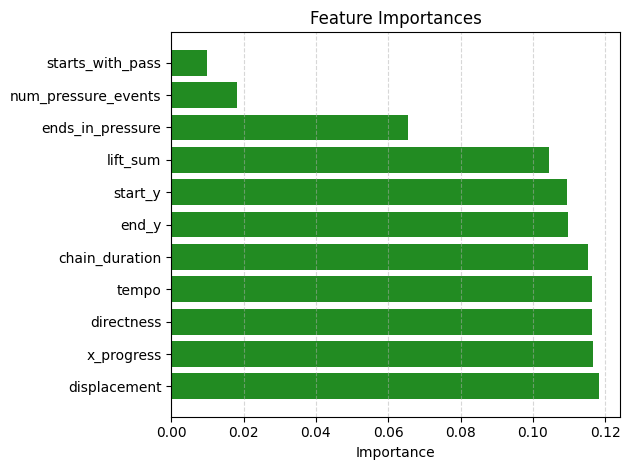

In [239]:
plt.barh(sorted_features['feature'], sorted_features['importance'], color='forestgreen')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Time Series Feature Engineering

## Model train with Tf-Idf features

In [158]:
X_test.shape

(20000, 24)

In [162]:
# fit tfidf on training data

train_tfidf, tfidf = generate_tfidf_matrix(X_train)
test_tfidf = tfidf.transform(X_test['event_sequence_str'])

In [163]:
train_tfidf.shape

(80000, 1461)

In [164]:
test_tfidf.shape

(20000, 1461)

In [165]:
tfidf_feature_names = tfidf.get_feature_names_out()
X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(
    train_tfidf
    , columns=tfidf_feature_names
    , index=X_train.index
)

X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(
    test_tfidf
    , columns=tfidf_feature_names
    , index=X_test.index
)

In [166]:
X_train_combined = pd.concat([X_train[train_features], X_train_tfidf], axis=1)
X_test_combined = pd.concat([X_test[train_features], X_test_tfidf], axis=1)

In [167]:
X_train_combined.head(10)

start_x  start_y  end_x  end_y  chain_duration     tempo  displacement  \
33338     30.9     57.1   16.0   32.7          10.971  0.638046     28.589683   
59046     85.2     29.2   12.9   46.8          72.872  0.096059     74.411357   
97182      1.7     45.0   36.5   33.6           6.444  1.086282     36.619667   
60540     78.3     17.7   85.2    1.4           4.617  1.516136     17.700282   
78708     49.2      5.8   55.4   21.7           3.843  1.821494     17.066048   
34952     76.3     18.2  100.3   28.6           6.954  1.006615     26.156452   
11389     33.7     19.5   60.3   46.2          11.922  0.587150     37.688858   
19509     27.1     15.2   81.9   72.8          15.862  0.441306     79.503459   
39005     27.6     66.6   74.6   15.9           2.360  2.966102     69.133856   
26045    111.1     57.7   42.0   16.9          47.691  0.146778     80.246184   

       directness  x_progress  starts_with_pass  ends_in_pressure  \
33338    4.084240       -14.9                 1                 0   
59046   10.630194       -72.3                 0                 0   
97182    5.231381        34.8                 0                 0   
60540    2.528612         6.9                 0                 0   
78708    2.438007         6.2                 1                 0   
34952    3.736636        24.0                 0                 0   
11389    5.384123        26.6                 1                 0   
19509   11.357637        54.8                 1                 0   
39005    9.876265        47.0                 1                 0   
26045   11.463741       -69.1                 0                 0   

       num_pressure_events  unique_event_count  lift_max  lift_mean  lift_sum  \
33338                    0                   4 -0.050891  -0.204577 -1.227461   
59046                    0                   7  0.808396   0.047673  0.286040   
97182                    0                   3  0.081051  -0.184296 -1.105777   
60540                    1                   4  0.187728  -0.128496 -0.770978   
78708                    1                   4  0.187728  -0.151480 -0.908878   
34952                    1                   5  0.187728  -0.106098 -0.636588   
11389                    0                   3 -0.105552  -0.215955 -1.295732   
19509                    1                   4  0.187728  -0.151480 -0.908878   
39005                    1                   6  0.187728  -0.038623 -0.231738   
26045                    0                   5 -0.050891  -0.230293 -1.381759   

       50  50 50  50 50 50  50 50 ball_recovery  50 50 block  50 50 carry  \
33338   0      0         0                    0            0            0   
59046   0      0         0                    0            0            0   
97182   0      0         0                    0            0            0   
60540   0      0         0                    0            0            0   
78708   0      0         0                    0            0            0   
34952   0      0         0                    0            0            0   
11389   0      0         0                    0            0            0   
19509   0      0         0                    0            0            0   
39005   0      0         0                    0            0            0   
26045   0      0         0                    0            0            0   

       50 50 clearance  50 50 pass  50 50 pressure  50 ball_recovery  \
33338                0           0               0                 0   
59046                0           0               0                 0   
97182                0           0               0                 0   
60540                0           0               0                 0   
78708                0           0               0                 0   
34952                0           0               0                 0   
11389                0           0               0                 0   
19509                0           0     

In [168]:
rf = RandomForestClassifier(
    n_estimators=200
    , max_depth=None
    , min_samples_split=4
    , min_samples_leaf=2
    , random_state=42
)

rf_results = model_train(X_train_combined, X_train.y, X_test_combined, X_test.y, rf)

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [169]:
rf_results

{'model': RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                        n_estimators=200, random_state=42),
 'pr_auc': 0.11862210433030264,
 'roc_auc': 0.851402332479775,
 'y_pred_proba': array([0.00023944, 0.0036887 , 0.07423293, ..., 0.00532613, 0.00046482,
        0.00064534])}

In [172]:
imps = rf_results['model'].feature_importances_
feature_importance_df = pd.DataFrame(
    {
        'feature': X_train_combined.columns,
        'importance': imps
    }
)

sorted_features = (
    feature_importance_df
    .sort_values("importance", ascending=False)
)

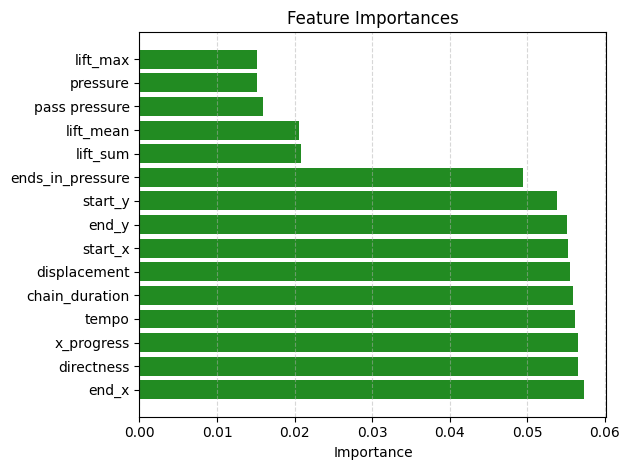

In [173]:
plt.barh(sorted_features.head(15)['feature'], sorted_features.head(15)['importance'], color='forestgreen')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [174]:
sorted_features.tail(10)

feature  importance
916                goal_keeper player_on pass         0.0
414                      carry clearance shot         0.0
920          goal_keeper pressure goal_keeper         0.0
924                    goal_keeper shot block         0.0
411                carry clearance miscontrol         0.0
409                          carry block shot         0.0
928     goal_keeper substitution substitution         0.0
929   goal_keeper substitution tactical_shift         0.0
930                goal_keeper tactical_shift         0.0
1476         tactical_shift substitution pass         0.0

In [175]:
# drop lowest importance features

sorted_features[sorted_features['importance'] == 0].feature

45                  bad_behaviour bad_behaviour
316                     block block goal_keeper
1104              own_goal_against own_goal_for
315                  block block foul_committed
46             bad_behaviour bad_behaviour pass
                         ...                   
409                            carry block shot
928       goal_keeper substitution substitution
929     goal_keeper substitution tactical_shift
930                  goal_keeper tactical_shift
1476           tactical_shift substitution pass
Name: feature, Length: 682, dtype: object

In [176]:
reduce_train_features = sorted_features[sorted_features['importance'] > 0].feature.values.tolist()

In [177]:
rf = RandomForestClassifier(
    n_estimators=200
    , max_depth=None
    # , min_samples_split=4
    # , min_samples_leaf=2
    , random_state=42
)

rf_results = model_train(X_train_combined[reduce_train_features], X_train.y, X_test_combined[reduce_train_features], X_test.y, rf)

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/sklearn/utils/validation.py:872: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [178]:
rf_results

{'model': RandomForestClassifier(n_estimators=200, random_state=42),
 'pr_auc': 0.105585889752443,
 'roc_auc': 0.826497671419995,
 'y_pred_proba': array([0.   , 0.   , 0.06 , ..., 0.005, 0.   , 0.   ])}

In [181]:
imps = rf_results['model'].feature_importances_
feature_importance_df = pd.DataFrame(
    {
        'feature': X_train_combined[reduce_train_features].columns,
        'importance': imps
    }
)

sorted_features = (
    feature_importance_df
    .sort_values("importance", ascending=False)
)

In [182]:
plt.barh(sorted_features.head(15)['feature'], sorted_features.head(15)['importance'], color='forestgreen')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## CountVectorizer

In [195]:
def generate_countvector_features(df, col="event_sequence_str", ngram_range=(1,3)):
    from sklearn.feature_extraction.text import CountVectorizer
    
    vectorizer = CountVectorizer(max_features=1000, ngram_range=ngram_range)
    X_counts = vectorizer.fit_transform(df[col])
    return X_counts, vectorizer

In [196]:
# fit tfidf on training data

train_vectorizer, vectorizer = generate_countvector_features(X_train)
test_vectorizer = vectorizer.transform(X_test['event_sequence_str'])

In [197]:
train_vectorizer.shape

(80000, 1000)

In [198]:
test_vectorizer.shape

(20000, 1000)

In [200]:
train_vectorizer

<80000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 1074848 stored elements in Compressed Sparse Row format>

In [165]:
vectorizer_feature_names = vectorizer.get_feature_names_out()
X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(
    train_tfidf
    , columns=tfidf_feature_names
    , index=X_train.index
)

X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(
    test_tfidf
    , columns=tfidf_feature_names
    , index=X_test.index
)

In [202]:
logit = LogisticRegression(max_iter=1000)
logit_results = model_train(train_vectorizer, X_train.y, test_vectorizer, X_test.y, logit)

In [203]:
logit_results

{'model': LogisticRegression(max_iter=1000),
 'pr_auc': 0.1150985516965984,
 'roc_auc': 0.8571159518979685,
 'y_pred_proba': array([0.00399428, 0.01118441, 0.15130602, ..., 0.00856561, 0.00210523,
        0.0028488 ])}

# Team Embeddings

To model contextual team behavior, we need generate embeddings capturing the team's history. To achieve this without feature leakage, we will do as follows : 

1. **Holding out the first 5 matches per team from the training set**
    - For a team’s embedding to be meaningful, it must be based on **enough historical context**.
    - The first 5 matches per team are used exclusively to **seed** their rolling stats.
    - These matches are **excluded from the training set** to avoid using future knowledge (leakage) when training the model on subsequent events.
   
2. **Exponential Weighted Moving Average (EWMA) Team Embeddings**
    - Traditional average-based embeddings treat all past matches equally.
    - EWMA allows **more recent matches to have greater influence**, better capturing current team form and tactical behavior.
    - This method balances **historical stability** with **tactical adaptiveness** over the season.
    - Mathematically, each stat is updated as:
      $$
      \text{ewma}\_{t} = \alpha \cdot \text{stat}\_{t} + (1 - \alpha) \cdot \text{ewma}_{t-1}
\text{, where } α \text{ is a smoothing factor (e.g., 0.3)}
$$


In [29]:
matches_df.columns

Index(['Unnamed: 0', 'match_id', 'match_date', 'kick_off', 'home_score',
       'away_score', 'match_status', 'last_updated', 'match_week',
       'competition.competition_id', 'competition.country_name',
       'competition.competition_name', 'season.season_id',
       'season.season_name', 'home_team.home_team_id',
       'home_team.home_team_name', 'home_team.managers',
       'away_team.away_team_id', 'away_team.away_team_name',
       'away_team.managers', 'competition_stage.id', 'competition_stage.name',
       'stadium.id', 'stadium.name', 'referee.id', 'referee.name',
       'referee.country.id', 'referee.country.name'],
      dtype='object')

### Team‑Level Feature Families for Foul‑Won Prediction

---

#### 1  Discipline & Physicality Profile
| Feature (per 90)               | Why it matters                                                                 | Calculation                                           |
|--------------------------------|--------------------------------------------------------------------------------|-------------------------------------------------------|
| **Fouls committed**            | Teams that commit lots of fouls often concede more as well (referee “make‑up”). | `fouls_committed / minutes_played * 90`               |
| **Cards per foul**             | Captures *severity* of infractions & referee perception.                       | `num_cards / fouls_committed`                         |
| **Duels & tackle attempts**    | High duel volume ⇒ more contact situations.                                    | Count `duel` + `tackle` events                        |
| **Average duel intensity**     | Aggressive teams both draw and concede fouls.                                   | Mean vendor “intensity” flag over duels               |

---

#### 2  Pressing & Defensive Zone Behaviour
| Feature                                   | Why it matters                                               | Calculation |
|-------------------------------------------|--------------------------------------------------------------|-------------|
| **PPDA** (passes allowed per defensive action) | Low PPDA = high press ⇒ more fouls in attacking third.       | `opp_passes / def_actions` |
| **Defensive action centroid (x‑pos)**     | Zone where team defends influences type/location of contact. | Mean `x` of defensive events |
| **% Defensive events in attacking third** | High press sides commit/draw tactical fouls high up.         | `def_actions_in_att_third / total_def_actions` |

---

#### 3  Possession & Tempo
| Feature                                | Why it matters                                             | Calculation |
|----------------------------------------|------------------------------------------------------------|-------------|
| **Average possession length (s)**      | Long possessions allow time to foul; short counters draw transition fouls. | Mean duration between possession start & end |
| **Direct speed (m/s)**                 | Fast vertical progression invites tactical fouls.          | `net_carry_or_pass_distance / possession_time` |
| **% Transitions starting in own half** | Counter‑attacking teams often get “stop‑the‑break” fouls.  | Flag possessions start < halfway & last < 10 s |

---

#### 4  Attacking Style & Ball Security
| Feature                         | Why it matters                              | Calculation |
|---------------------------------|---------------------------------------------|-------------|
| **Dribbles attempted / 90**     | Dribble‑heavy teams draw more fouls.        | Count `dribble` events |
| **Carry distance / 90**         | Carriers invite contact.                    | Σ carry metres / 90 |
| **Pass‑length distribution**    | Style (short vs. long) affects foul zones.  | Bin passes into short/med/long ratios |

---

#### 5  Contextual Tendencies
| Feature                               | Why it matters                                   | Calculation |
|---------------------------------------|--------------------------------------------------|-------------|
| **Home‑vs‑away foul differential**    | Some teams get more calls at home.               | `fouls_drawn_home − fouls_drawn_away` |
| **Referee interaction index**         | Certain team‑ref combinations skew foul counts.  | EWMA of card differential in matches with each ref |
| **Game‑state foul rate (lead/trail)** | Teams trailing press harder and draw more fouls. | Per‑90 foul rates split by score state |

---

#### 6  Temporal Smoothing Example (EWMA)

```python
team_agg = raw_team_match_stats.sort_values('match_date')
team_agg['fouls_drawn_EWMA'] = (
    team_agg['fouls_drawn_per90']
      .ewm(alpha=0.35, adjust=False)
      .mean()
)

In [6]:
def build_team_match_base(match_df, min_history=5):
    match_df = match_df.sort_values("match_date").reset_index(drop=True)
    # get first N matches per team
    knowledge_base_team_matches = {
        team: list() for team in match_df['home_team.home_team_id'].unique()
    }
    knowledge_base_match_ids = set()
    team_cols = ["home_team.home_team_id","away_team.away_team_id"]
    for team in knowledge_base_team_matches:
        # 3 home matches + 2 away matches = 5 total matches per team
        home_matches = match_df[match_df["home_team.home_team_id"] == team]
        away_matches = match_df[match_df["away_team.away_team_id"] == team]
        team_matches = pd.concat([home_matches, away_matches])
        team_matches = team_matches.sort_values("match_date").head(min_history)
        match_ids = team_matches["match_id"].tolist()
        knowledge_base_team_matches[team] = match_ids
        knowledge_base_match_ids.update(match_ids)
    return knowledge_base_team_matches, knowledge_base_match_ids

In [10]:
team_match_dict, knowledge_base_match_ids = build_team_match_base(matches_df)

In [11]:
print(f"Total knowledge base matches: {len(knowledge_base_match_ids)}")

Total knowledge base matches: 50


In [55]:
def get_x(loc):
    if isinstance(loc, str):
        return float(loc.split(",")[0])
    return None
    
def build_defensive_context(team_events, N=5):
    # Defensive actions by this team
    defensive_actions = team_events[team_events["type.name"].isin([
        "foul_committed", "tackle", "interception", "pressure", "block"
    ])]

    fouls_committed = (team_events["type.name"] == "foul_committed").sum()
    fouls_won = (team_events["type.name"] == "foul_won").sum()
    
    duel_tackle_counts = team_events["type.name"].isin(["duel", "tackle"]).sum()
    duel_success = team_events[
        (team_events["type.name"] == "duel") 
        & (team_events["duel.outcome.name"].isin(["Success In Play", "Won", "Success Out"]))
    ].shape[0]

    # minutes played
    match_minutes = team_events.groupby("match_id")["minute"].max().sum()

    # fouls
    fouls_per_90 = fouls_committed / N
    fouls_per_event = fouls_committed / team_events.shape[0]
    fouls_won_per_90 = fouls_won / N
    # duels
    duels_per_90 = duel_tackle_counts / N
    duels_per_event = duel_tackle_counts / team_events.shape[0]
    # foul committed per duel
    fouls_committed_per_duel = (fouls_committed/duel_tackle_counts) if duel_tackle_counts > 0 else 0 

    return {
        "fouls_committed_per90": fouls_per_90,
        "fouls_won_per90": fouls_won_per_90,
        "fouls_committed_per_event": fouls_per_event,
        "fouls_committed_per_duel": fouls_committed_per_duel,
        "duel_tackle_per90": duels_per_90,
        "duel_tackle_per_event": duels_per_event,
        "duel_success_rate": duel_success / duel_tackle_counts if duel_tackle_counts > 0 else 0
    }

def build_pressing_context(team_events, opponent_events, N=5):
    # passess by oppponent
    opponent_passes = opponent_events[opponent_events["type.name"] == "pass"]
    defensive_actions = team_events[
        team_events["type.name"].isin(
            [
                "foul_committed", "tackle", "interception", "pressure", "block"
            ]
        )
    ]
    # passes allowed per defensive action - PPDA
    num_defensive_actions = len(defensive_actions)
    num_opp_passes = len(opponent_passes)
    ppda = num_opp_passes / num_defensive_actions if num_defensive_actions > 0 else None

    # Defensive action centroid (mean x)
    defensive_x = defensive_actions["location"].dropna().apply(get_x)
    defensive_centroid_x = defensive_x.mean() if not defensive_x.empty else None

    # Proportion of defensive actions in attacking third
    defensive_in_attacking_third = defensive_x[defensive_x > 66].count()
    prop_attacking_third = defensive_in_attacking_third / num_defensive_actions if num_defensive_actions > 0 else None
    
    return {
        "num_opponent_passes": num_opp_passes,
        "num_defensive_actions": num_defensive_actions,
        "ppda": ppda,
        "def_action_centroid_x": defensive_centroid_x,
        "percent_def_actions_att_third": prop_attacking_third
    }
    
def build_possession_context(team_events):
    # Possession based stats
    team_possession_chains = team_events.groupby("possession")
    possession_durations = []
    direct_speeds = []
    counter_flags = []

    for _, possession_chain in team_possession_chains:
        possession_chain = possession_chain.sort_values("index")
        if len(possession_chain) < 2:
            # too short to compute features
            continue
        
        # duration
        parsed_timestamps = possession_chain["timestamp"].apply(parse_timestamp).values
        chain_duration = parsed_timestamps[-1] - parsed_timestamps[0]

        x_start = get_x(possession_chain.iloc[0]["location"])
        x_end = get_x(possession_chain.iloc[-1]["location"])

        if x_start != None and x_end != None and chain_duration > 0:
            x_progress = abs(x_end - x_start)
            direct_speed = x_progress/chain_duration
            direct_speeds.append(direct_speed)

            possession_durations.append(chain_duration)
            # transitioning from own half and quickly
            is_counter = (x_start < 50) and (chain_duration < 10)
            counter_flags.append(is_counter)

    avg_possession_duration = np.mean(possession_durations) if possession_durations else 0
    avg_direct_speed = np.mean(direct_speeds) if direct_speeds else 0
    avg_counters = np.mean(counter_flags) if counter_flags else 0

    return {
        "avg_possession_duration": avg_possession_duration,
        "avg_direct_speed": avg_direct_speed,
        "avg_counters": avg_counters,
        "num_possessions": len(team_possession_chains),
        "valid_possessions": len(possession_durations)                      
    }

def build_attacking_context(team_events, N=5):
    # dribbles
    dribbles = (team_events["type.name"] == "dribble").sum()
    # carries
    carries = (team_events["type.name"] == "carry").sum()
    # passes 
    passes = team_events[team_events["type.name"] == 'pass']
    pass_lengths = passes["pass.length"].dropna()
    short = pass_lengths[pass_lengths < 10].count()
    medium = pass_lengths[(pass_lengths >= 10) & (pass_lengths < 30)].count()
    long = pass_lengths[pass_lengths >= 30].count()
    total_passes = short + medium + long

    dribbles_per_90 = dribbles/N
    carries_per_90 = carries/N
    short_pass_prop = short/total_passes
    medium_pass_prop = medium/total_passes
    long_pass_prop = long/total_passes

    return {
        "dribbles_per_90": dribbles_per_90,
        "carries_per_90": carries_per_90,
        "short_pass_prop": short_pass_prop,
        "medium_pass_prop": medium_pass_prop,
        "long_pass_prop": long_pass_prop,
        "total_passes": total_passes
    }
def build_foul_context(team_events, matches, match_ids, team_id, N=5):
    ref_ewma = {}
    home_fouls = 0
    away_fouls = 0

    leading_fouls = 0
    trailing_fouls = 0
    leading_minutes = 0
    trailing_minutes = 0
    
    for match_id in match_ids:
        match = matches[matches["match_id"] == match_id].iloc[0]
        match_events = team_events[team_events["match_id"] == match_id]
        team_side = "home" if match["home_team.home_team_id"] == team_id else "away"
        is_home = team_side == "home"
        referee = match["referee.id"]

        # fouls drawn
        fouls_drawn = match_events[
            (match_events["type.name"] == "foul_won") 
            & (match_events["team.id"] == team_id)
        ].shape[0]
        if is_home:
            home_fouls += fouls_drawn
        else:
            away_fouls += fouls_drawn
        
        # Foul differential: fouls won - fouls committed
        fouls_drawn = match_events[
            (match_events["type.name"] == "foul_won") &
            (match_events["team.id"] == team_id)
        ].shape[0]
        
        fouls_committed = match_events[
            (match_events["type.name"] == "foul_committed") &
            (match_events["team.id"] == team_id)
        ].shape[0]
        
        foul_diff = fouls_drawn - fouls_committed
        
        # EWMA of foul differential per referee
        ewma_alpha = 0.3
        prev_ewma = ref_ewma.get(referee, 0)
        ref_ewma[referee] = ewma_alpha * foul_diff + (1 - ewma_alpha) * prev_ewma

        # Game-state foul stats
        # We use final match score as a proxy since full timeline may not be available
        home_goals = match.get("home_score", 0)
        away_goals = match.get("away_score", 0)

        if is_home:
            # if leading, update leading stats, else trailing stats
            if home_goals > away_goals:
                leading_fouls += fouls_committed
                leading_minutes += 90
            elif home_goals < away_goals:
                trailing_fouls += fouls_committed
                trailing_minutes += 90
        else:
            if away_goals > home_goals:
                leading_fouls += fouls_committed
                leading_minutes += 90
            elif away_goals < home_goals:
                trailing_fouls += fouls_committed
                trailing_minutes += 90
    
    ref_interaction_index = np.mean(list(ref_ewma.values())) if ref_ewma else 0
    foul_diff_home_away = home_fouls - away_fouls
    fouls_per90_leading = leading_fouls / (leading_minutes / 90) if leading_minutes > 0 else 0
    fouls_per90_trailing = trailing_fouls / (trailing_minutes / 90) if trailing_minutes > 0 else 0
    
    return {
        "home_away_foul_diff":foul_diff_home_away,
        "referee_interaction_index":ref_interaction_index,
        "fouls_per90_leading":fouls_per90_leading,
        "fouls_per90_trailing":fouls_per90_trailing
    }

In [56]:
def compute_team_embeddings(events_df, matches_df, team_knowledge_base_matches,event_exclusions=['error', 'starting_xi', 'half_start', 'half_end']):
    from collections import defaultdict
    import numpy as np
    import pandas as pd

    embeddings = []
    events_df['type.name'] = events_df['type.name'].str.lower().str.replace(' ', '_').str.replace('*','').str.strip()
    events_df = events_df.loc[~events_df['type.name'].isin(event_exclusions)]
    for team_id, match_ids in team_knowledge_base_matches.items():
        team_events = events_df[
            (events_df["match_id"].isin(match_ids)) &
            (events_df["team.id"] == team_id)
        ]
        # All events where the opponent is involved
        opponent_events = events_df[
            (events_df["match_id"].isin(match_ids)) &
            (events_df["team.id"] != team_id)
        ]
        # Defensive Context
        defensive_context = build_defensive_context(team_events)
        # Pressing Context
        pressing_context = build_pressing_context(team_events, opponent_events)
        # Possession Context
        possession_context = build_possession_context(team_events)
        # Attacking Context
        attacking_context = build_attacking_context(team_events)
        # Foul Context
        foul_context = build_foul_context(team_events, matches_df, match_ids, team_id)

        team_embedding = {
            "team_id": team_id,
            **defensive_context,
            **pressing_context,
            **possession_context,
            **attacking_context,
            **foul_context
        }
        embeddings.append(team_embedding)
    return pd.DataFrame(embeddings)

In [57]:
team_embeddings = compute_team_embeddings(
    events_df,
    matches_df,
    team_match_dict
)

In [58]:
team_embeddings.head()

team_id  fouls_committed_per90  fouls_won_per90  fouls_committed_per_event  \
0       33                   14.4             16.6                   0.007773   
1       39                   13.2             12.8                   0.006254   
2       28                   13.4             13.2                   0.007647   
3       29                   10.4             14.8                   0.006145   
4       56                   13.6              9.8                   0.008213   

   fouls_committed_per_duel  duel_tackle_per90  duel_tackle_per_event  \
0                  0.382979               37.6               0.020296   
1                  0.331658               39.8               0.018857   
2                  0.338384               39.6               0.022598   
3                  0.305882               34.0               0.020090   
4                  0.386364               35.2               0.021256   

   duel_success_rate  num_opponent_passes  num_defensive_actions      ppda  \
0           0.297872                 2112                    869  2.430380   
1           0.286432                 2218                    779  2.847240   
2           0.297980                 2245                    920  2.440217   
3           0.347059                 2520                    795  3.169811   
4           0.295455                 2370                    868  2.730415   

   def_action_centroid_x  percent_def_actions_att_third  \
0              51.082739                       0.310702   
1              57.847368                       0.368421   
2              54.490435                       0.355435   
3              47.565409                       0.276730   
4              53.293664                       0.320276   

   avg_possession_duration  avg_direct_speed  avg_counters  num_possessions  \
0               340.010904          0.308313      0.031847              191   
1               396.174544          0.196428      0.000000              194   
2               417.912641          0.619213      0.023952              207   
3               462.794127          0.464996      0.024242              201   
4               425.938714          0.382712      0.000000              188   

   valid_possessions  dribbles_per_90  carries_per_90  short_pass_prop  \
0                157             16.2           412.4         0.191577   
1                169             14.0           521.2         0.158112   
2                167             19.4           369.8         0.199767   
3                165             17.2           376.0         0.171593   
4                147             18.0           365.2         0.201674   

   medium_pass_prop  long_pass_prop  total_passes  home_away_foul_diff  \
0          0.617965        0.190458          2683                   -7   
1          0.648606        0.193283          3156                   18   
2          0.595803        0.204431          2573                    0   
3          0.610016        0.218391          2436                    8   
4          0.586192        0.212134          2390                   25   

   referee_interaction_index  fouls_per90_leading  fouls_per90_trailing  
0                     0.6600            14.000000             13.333333  
1                    -0.1200            10.666667             16.000000  
2                    -0.0600            14.000000             14.666667  
3                     1.4925            14.000000              6.000000  
4                    -1.1400            10.000000             15.000000

In [59]:
team_embeddings.shape

(20, 28)

In [60]:
team_embeddings.to_csv("team_embeddings.csv")

In [5]:
team_embeddings = pd.read_csv("team_embeddings.csv")

## Model Traning w/ Static Team Embeddings

In [12]:
# build training data excluding the matches in team's knowledge base

train_event_df = events_df[~events_df["match_id"].isin(knowledge_base_match_ids)]
train_event_df.shape

(1140959, 49)

In [22]:
train_event_df, model_df = prepare_data_for_model(train_event_df)
model_df.head()

match_id  possession  player_possession  n_events  first_event_idx
0   3753972           2                  6         1                6
1   3753972           2                  7         1                9
2   3753972           2                  8         1               12
3   3753972           2                  9         1               15
4   3753972           2                 10         1               18

In [23]:
model_df.shape

(328788, 5)

In [24]:
model_df = generate_target_label(train_event_df, model_df)

In [25]:
model_df.shape

(328788, 6)

In [26]:
model_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.992384
1    0.007616
Name: proportion, dtype: float64

In [27]:
model_df.to_csv("model_df.csv")
train_event_df.to_csv("events_excluding_first_5_matches.csv")

In [13]:
model_df = pd.read_csv("model_df.csv")

In [18]:
train_event_df = pd.read_csv("events_excluding_first_5_matches.csv")

In [14]:
# downsample while maintaining time element

events_200000_df = model_df.iloc[:200000]
events_200000_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.99238
1    0.00762
Name: proportion, dtype: float64

In [15]:
# downsample majority class, but not by much. Winning a foul after recieving/recovering the ball is still a rarity
class1 = events_200000_df[events_200000_df['is_foul_won'] == 1]
class0 = events_200000_df[events_200000_df['is_foul_won'] == 0]

n_class1 = class1.shape[0]
class1_ratio = 0.02
n_class0 = int(n_class1 / class1_ratio)

class0_downsampled = class0.sample(n_class0, random_state=42)

sampled_model_df = pd.concat([class1, class0_downsampled]).sort_index()
sampled_model_df.is_foul_won.value_counts(normalize=True)

is_foul_won
0    0.980392
1    0.019608
Name: proportion, dtype: float64

In [16]:
sampled_model_df.shape

(77724, 7)

In [19]:
N = 7

context_df = prepare_event_context(matches_df, train_event_df, sampled_model_df , N)

/var/folders/xz/9p327hsj39n6prk52zdm1x4h0000gn/T/ipykernel_26028/285664439.py:64: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  is_home_team = int(home_team == recovery_reciept_event['team.name'])


In [20]:
context_df.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972          6           2                6             0           5   
1   3753972         10           2               18             0           5   
2   3753972         12           2               24             0           5   
3   3753972         18           3               36             0           5   
4   3753972         19           3               39             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [carry, pressure, foul_committed, foul_won, sh...  0     97.4     74.0   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     53.1     42.3   
2  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
3  [ball_receipt, pass, ball_receipt, pass, ball_...  0      2.4     38.8   
4  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   

   end_x  end_y  chain_length  chain_duration     tempo  displacement  \
0   61.0   40.1             7       -2985.462  7.000000     49.741029   
1   28.5   33.9             7           5.753  1.216756     25.994615   
2   31.9   31.1             7           7.069  0.990239      4.404543   
3   40.8   23.1             7           6.911  1.012878     41.485540   
4   90.6   60.0             7           7.868  0.889680     90.892519   

   directness  x_progress  
0    7.105861       -36.4  
1    3.713516       -24.6  
2    0.629220         3.4  
3    5.926506        38.4  
4   12.984646        75.1

In [21]:
context_df = generate_sequence_features(context_df)

In [22]:
context_df.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972          6           2                6             0           5   
1   3753972         10           2               18             0           5   
2   3753972         12           2               24             0           5   
3   3753972         18           3               36             0           5   
4   3753972         19           3               39             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [carry, pressure, foul_committed, foul_won, sh...  0     97.4     74.0   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     53.1     42.3   
2  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
3  [ball_receipt, pass, ball_receipt, pass, ball_...  0      2.4     38.8   
4  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   

   ...     tempo  displacement  directness  x_progress  \
0  ...  7.000000     49.741029    7.105861       -36.4   
1  ...  1.216756     25.994615    3.713516       -24.6   
2  ...  0.990239      4.404543    0.629220         3.4   
3  ...  1.012878     41.485540    5.926506        38.4   
4  ...  0.889680     90.892519   12.984646        75.1   

                                  event_sequence_str  sequence_length  \
0  carry pressure foul_committed foul_won shot go...                7   
1  pass ball_receipt carry pass ball_receipt carr...                7   
2  pass ball_receipt carry pass ball_receipt carr...                7   
3  ball_receipt pass ball_receipt pass ball_recei...                7   
4  pass ball_receipt pass pressure ball_receipt c...                7   

   starts_with_pass  ends_in_pressure num_pressure_events  unique_event_count  
0                 0                 0                   1                   7  
1                 1                 0                   0                   3  
2                 1                 0                   0                   3  
3                 0                 1                   1                   3  
4                 1                 0                   1                   4  

[5 rows x 24 columns]

In [23]:
# remove events with chain_duration <= 0

context_df = context_df[context_df.chain_duration > 0]
context_df.y.value_counts(normalize=True)

y
0    0.980314
1    0.019686
Name: proportion, dtype: float64

In [24]:
# split into train-test before markov modelling

train_size = int(0.8*context_df.shape[0])
X_train, X_test = context_df[:train_size].copy(), context_df[train_size:].copy()

X_train.shape, X_test.shape

((61932, 24), (15484, 24))

In [25]:
X_train.y.value_counts(normalize=True), X_test.y.value_counts(normalize=True)

(y
 0    0.980511
 1    0.019489
 Name: proportion, dtype: float64,
 y
 0    0.979527
 1    0.020473
 Name: proportion, dtype: float64)

In [26]:
class1_sequences = X_train[X_train.y == 1]['event_sequence']
class0_sequences = X_train[X_train.y == 0]['event_sequence']

class1_model = EventMarkovModel(class1_sequences).fit()
class0_model = EventMarkovModel(class0_sequences).fit()

lift_matrix = class1_model.compute_lift_matrix(class0_model)

In [27]:
# compute lift features
X_train = generate_markov_lift_features(X_train, lift_matrix)
X_test = generate_markov_lift_features(X_test, lift_matrix)

In [28]:
X_train["log_score_sequence_class1"] = X_train["event_sequence"].apply(class1_model.score_sequence)
X_train["log_score_sequence_class0"] = X_train["event_sequence"].apply(class0_model.score_sequence)

X_test["log_score_sequence_class1"] = X_test["event_sequence"].apply(class1_model.score_sequence)
X_test["log_score_sequence_class0"] = X_test["event_sequence"].apply(class0_model.score_sequence)

In [52]:
pd.set_option('display.max_columns',None)
X_train.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
1   3753972         10           2               18             0           5   
2   3753972         12           2               24             0           5   
3   3753972         18           3               36             0           5   
4   3753972         19           3               39             0           5   
5   3753972         30           3               67             0           5   

                                      event_sequence  y  start_x  start_y  \
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     53.1     42.3   
2  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
3  [ball_receipt, pass, ball_receipt, pass, ball_...  0      2.4     38.8   
4  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   
5  [miscontrol, ball_recovery, carry, pressure, p...  0     28.0     53.9   

   end_x  end_y  chain_length  chain_duration     tempo  displacement  \
1   28.5   33.9             7           5.753  1.216756     25.994615   
2   31.9   31.1             7           7.069  0.990239      4.404543   
3   40.8   23.1             7           6.911  1.012878     41.485540   
4   90.6   60.0             7           7.868  0.889680     90.892519   
5   84.5   16.8             7           4.919  1.423053     67.591863   

   directness  x_progress  lift_max  lift_mean  lift_sum  \
1    3.713516       -24.6 -0.103598  -0.214364 -1.286186   
2    0.629220         3.4 -0.103598  -0.214364 -1.286186   
3    5.926506        38.4  1.246457   0.101139  0.606835   
4   12.984646        75.1  1.246457   0.099331  0.595986   
5    9.655980        56.5  0.139021  -0.081200 -0.487197   

   log_score_sequence_class1  log_score_sequence_class0  
1                  -3.189547                  -1.903361  
2                  -3.189547                  -1.903361  
3                  -6.389201                  -6.996036  
4                  -5.345960                  -5.941946  
5                  -6.467399                  -5.980202

In [53]:
X_train.columns

Index(['match_id', 'player_id', 'possession', 'first_event_idx',
       'is_home_team', 'referee_id', 'event_sequence', 'y', 'start_x',
       'start_y', 'end_x', 'end_y', 'chain_length', 'chain_duration', 'tempo',
       'displacement', 'directness', 'x_progress', 'lift_max', 'lift_mean',
       'lift_sum', 'log_score_sequence_class1', 'log_score_sequence_class0'],
      dtype='object')

In [60]:
train_features = [
    'is_home_team', 'referee_id',
    'start_x','start_y', 'end_x', 'end_y', 'chain_duration', 'tempo',
    'displacement', 'directness', 'x_progress','starts_with_pass', 'ends_in_pressure',
    'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
    'lift_sum','log_score_sequence_class1', 'log_score_sequence_class0'
]

In [29]:
# get team ids for the rows
event_lookup = train_event_df[["index", "team.id"]].rename(columns={"index": "first_event_idx"})
X_train = X_train.merge(event_lookup, on="first_event_idx", how="left")
X_test = X_test.merge(event_lookup, on="first_event_idx", how="left")

In [30]:
del event_lookup

In [31]:
# get the opponent team id
match_lookup = matches_df[["match_id", "home_team.home_team_id", "away_team.away_team_id"]]

X_train = X_train.merge(match_lookup, on="match_id", how="left")
X_test = X_test.merge(match_lookup, on="match_id", how="left")

def get_opponent_team_id(row):
    team_id = None
    if row["team.id"] == row["home_team.home_team_id"]:
        team_id = row["away_team.away_team_id"]
    else: team_id = row["away_team.away_team_id"]
    return team_id

X_train["opponent_team_id"] = X_train.apply(get_opponent_team_id, axis=1)
X_test["opponent_team_id"] = X_test.apply(get_opponent_team_id, axis=1)

In [32]:
del match_lookup

In [33]:
del events_df

In [34]:
team_embedding_self = team_embeddings.rename(columns={"team_id": "team.id"})
team_embedding_opponent = team_embeddings.rename(columns={"team_id": "opponent_team_id"})

In [35]:
def prefix_columns(df, key_col, prefix):
    return df.rename(columns={col: f"{prefix}{col}" for col in df.columns if col != key_col})

In [36]:
team_embed_prefixed = prefix_columns(team_embedding_self, key_col="team.id", prefix="self_")
opp_embed_prefixed = prefix_columns(team_embedding_opponent, key_col="opponent_team_id", prefix="opponent_")

In [37]:
X_train = X_train.merge(team_embed_prefixed, on="team.id", how="left")

In [38]:
X_train = X_train.merge(opp_embed_prefixed, on="opponent_team_id", how="left")

In [39]:
X_train.to_csv("x_train.csv")
del X_train

In [40]:
X_test = X_test.merge(team_embed_prefixed, on="team.id", how="left")

In [41]:
X_test = X_test.merge(opp_embed_prefixed, on="opponent_team_id", how="left")

In [42]:
X_test.to_csv("x_test.csv")
del X_test

In [3]:
X_train = pd.read_csv("x_train.csv")

In [13]:
X_test = pd.read_csv("x_test.csv")

In [4]:
X_train.columns

Index(['Unnamed: 0', 'match_id', 'player_id', 'possession', 'first_event_idx',
       'is_home_team', 'referee_id', 'event_sequence', 'y', 'start_x',
       'start_y', 'end_x', 'end_y', 'chain_length', 'chain_duration', 'tempo',
       'displacement', 'directness', 'x_progress', 'event_sequence_str',
       'sequence_length', 'starts_with_pass', 'ends_in_pressure',
       'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
       'lift_sum', 'log_score_sequence_class1', 'log_score_sequence_class0',
       'team.id', 'home_team.home_team_id', 'away_team.away_team_id',
       'opponent_team_id', 'self_Unnamed: 0', 'self_fouls_committed_per90',
       'self_fouls_won_per90', 'self_fouls_committed_per_event',
       'self_fouls_committed_per_duel', 'self_duel_tackle_per90',
       'self_duel_tackle_per_event', 'self_duel_success_rate',
       'self_num_opponent_passes', 'self_num_defensive_actions', 'self_ppda',
       'self_def_action_centroid_x', 'self_percent_def_actio

In [5]:
feature_subset = [
    'is_home_team', 'referee_id',
    'start_x','start_y', 'end_x', 'end_y', 'chain_duration', 'tempo',
    'displacement', 'directness', 'x_progress','starts_with_pass', 'ends_in_pressure',
    'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
    'lift_sum','log_score_sequence_class1', 'log_score_sequence_class0'
]

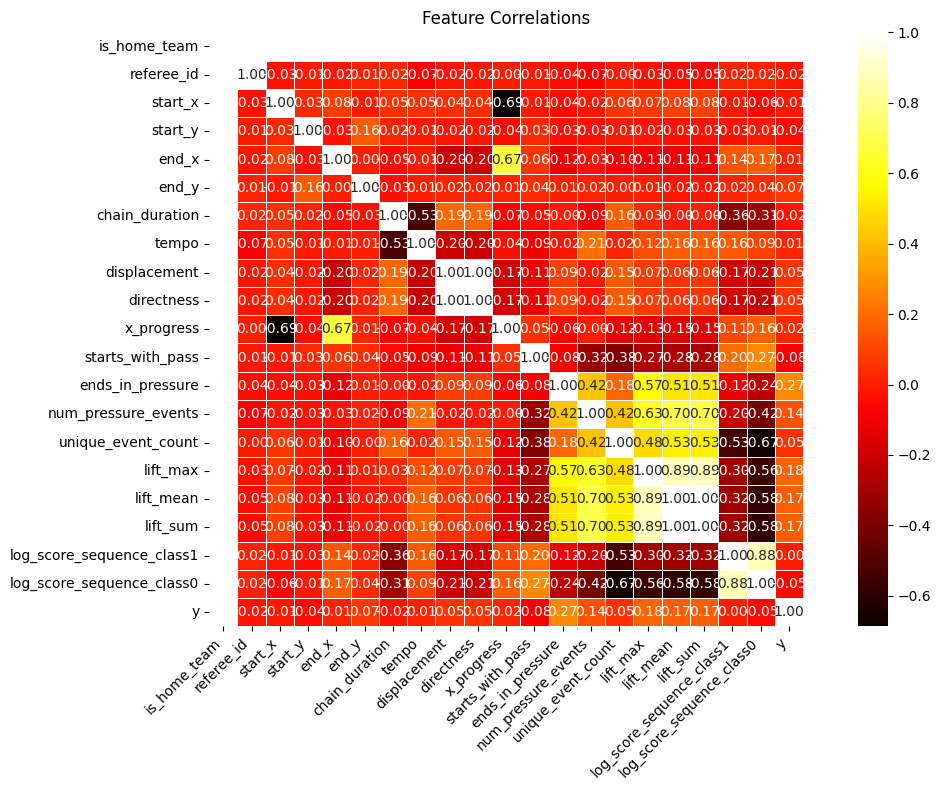

In [7]:
corr = X_train.sample(1000)[feature_subset+['y']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="hot", linewidths=0.5, square=True)
plt.title("Feature Correlations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

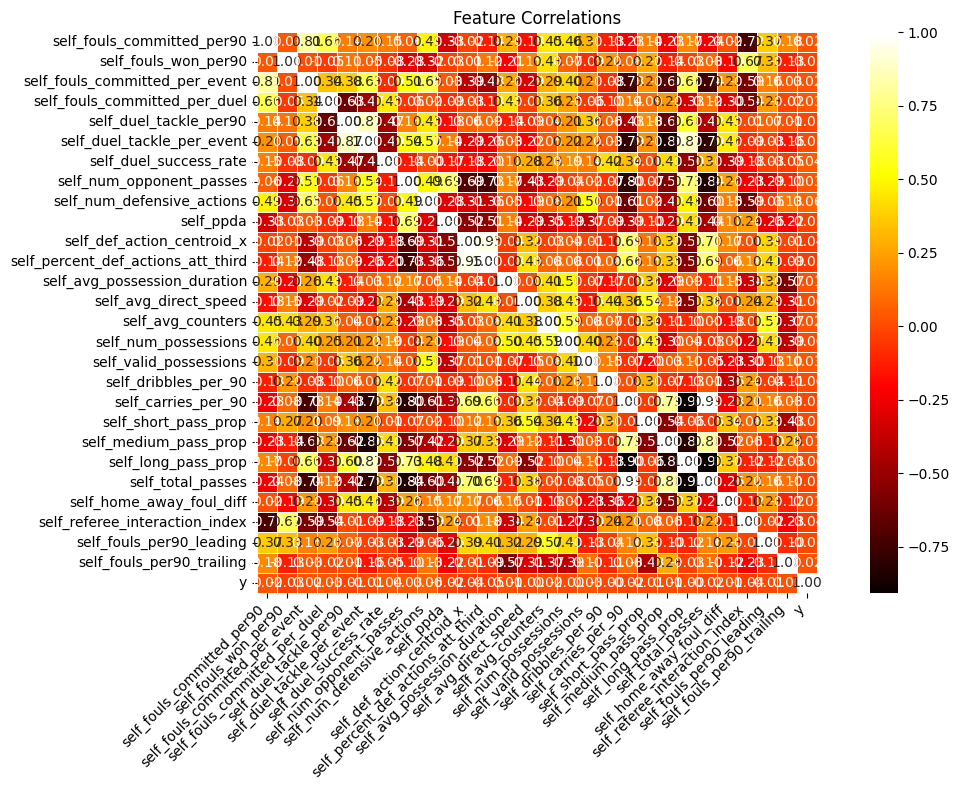

In [8]:
feature_subset = [
    'self_fouls_committed_per90',
   'self_fouls_won_per90', 'self_fouls_committed_per_event',
   'self_fouls_committed_per_duel', 'self_duel_tackle_per90',
   'self_duel_tackle_per_event', 'self_duel_success_rate',
   'self_num_opponent_passes', 'self_num_defensive_actions', 'self_ppda',
   'self_def_action_centroid_x', 'self_percent_def_actions_att_third',
   'self_avg_possession_duration', 'self_avg_direct_speed',
   'self_avg_counters', 'self_num_possessions', 'self_valid_possessions',
   'self_dribbles_per_90', 'self_carries_per_90', 'self_short_pass_prop',
   'self_medium_pass_prop', 'self_long_pass_prop', 'self_total_passes',
   'self_home_away_foul_diff', 'self_referee_interaction_index',
   'self_fouls_per90_leading', 'self_fouls_per90_trailing'
]
corr = X_train.sample(1000)[feature_subset+['y']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="hot", linewidths=0.5, square=True)
plt.title("Feature Correlations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

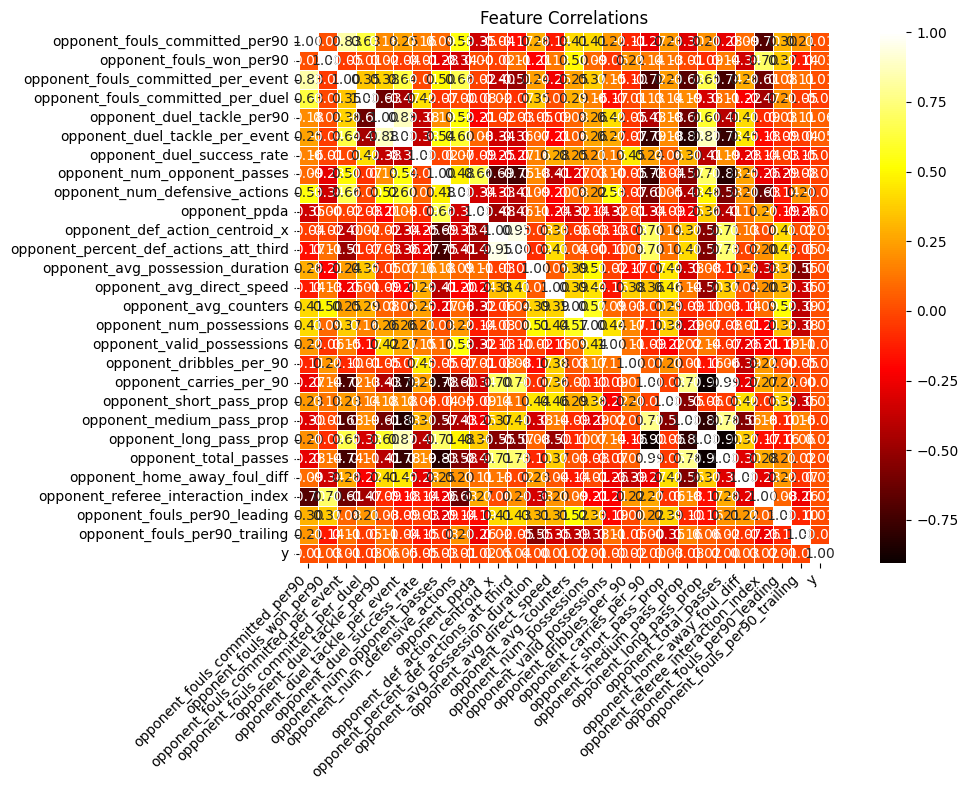

In [9]:
feature_subset = [
   'opponent_fouls_committed_per90',
   'opponent_fouls_won_per90', 'opponent_fouls_committed_per_event',
   'opponent_fouls_committed_per_duel', 'opponent_duel_tackle_per90',
   'opponent_duel_tackle_per_event', 'opponent_duel_success_rate',
   'opponent_num_opponent_passes', 'opponent_num_defensive_actions',
   'opponent_ppda', 'opponent_def_action_centroid_x',
   'opponent_percent_def_actions_att_third',
   'opponent_avg_possession_duration', 'opponent_avg_direct_speed',
   'opponent_avg_counters', 'opponent_num_possessions',
   'opponent_valid_possessions', 'opponent_dribbles_per_90',
   'opponent_carries_per_90', 'opponent_short_pass_prop',
   'opponent_medium_pass_prop', 'opponent_long_pass_prop',
   'opponent_total_passes', 'opponent_home_away_foul_diff',
   'opponent_referee_interaction_index', 'opponent_fouls_per90_leading',
   'opponent_fouls_per90_trailing'
]
corr = X_train.sample(1000)[feature_subset+['y']].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="hot", linewidths=0.5, square=True)
plt.title("Feature Correlations")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
train_features = [
    'is_home_team', 'referee_id',
    'start_x','start_y', 'end_x', 'end_y', 'chain_duration', 'tempo',
    'displacement', 'directness', 'x_progress','starts_with_pass', 'ends_in_pressure',
    'num_pressure_events', 'unique_event_count', 'lift_max', 'lift_mean',
    'lift_sum','log_score_sequence_class1', 'log_score_sequence_class0',
    'self_fouls_committed_per90',
    'self_fouls_won_per90', 'self_fouls_committed_per_event',
    'self_fouls_committed_per_duel', 'self_duel_tackle_per90',
    'self_duel_tackle_per_event', 'self_duel_success_rate',
    'self_num_opponent_passes', 'self_num_defensive_actions', 'self_ppda',
    'self_def_action_centroid_x', 'self_percent_def_actions_att_third',
    'self_avg_possession_duration', 'self_avg_direct_speed',
    'self_avg_counters', 'self_num_possessions', 'self_valid_possessions',
    'self_dribbles_per_90', 'self_carries_per_90', 'self_short_pass_prop',
    'self_medium_pass_prop', 'self_long_pass_prop', 'self_total_passes',
    'self_home_away_foul_diff', 'self_referee_interaction_index',
    'self_fouls_per90_leading', 'self_fouls_per90_trailing'
]
redundant_features = [
    "lift_max", "lift_mean", "start_x", "end_x", "unique_event_count"
]
train_features = [f for f in train_features if f not in redundant_features]

In [11]:
# training without Tf-Idf vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score, f1_score
)

def model_train(X_train, y_train, X_test, y_test, model):
    result_dict = {}
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    result_dict = {
        "model": model,
        "pr_auc": average_precision_score(y_test, y_pred_proba)
        , "roc_auc": roc_auc_score(y_test, y_pred_proba)
        # , "f1_score": f1_score(y_test, y_pred_proba)
        , "y_pred_proba": y_pred_proba
    }
    return result_dict

/Users/cntrl-station/miniforge3/envs/dev/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [64]:
light_gbm = LGBMClassifier(
    objective='binary'
    , boosting_type='gbdt'
    , n_estimators=500
    , learning_rate=0.001
    , num_leaves=32
    , max_depth=10
    # , min_child_samples=20
    # , subsample=0.8
    # , colsample_bytree=0.8
    , reg_alpha=0.1
    , reg_lambda=0.1
    , is_unbalance=True
    , random_state=42
)

gbm_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, light_gbm)
gbm_results

[LightGBM] [Info] Number of positive: 607, number of negative: 30278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2064
[LightGBM] [Info] Number of data points in the train set: 30885, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.019654 -> initscore=-3.909648
[LightGBM] [Info] Start training from score -3.909648


{'model': LGBMClassifier(is_unbalance=True, learning_rate=0.001, max_depth=10,
                n_estimators=500, num_leaves=32, objective='binary',
                random_state=42, reg_alpha=0.1, reg_lambda=0.1),
 'pr_auc': 0.1288896804547338,
 'roc_auc': 0.8726642014439162,
 'y_pred_proba': array([0.15839256, 0.05198732, 0.02453037, ..., 0.02572995, 0.03707743,
        0.06795121])}

In [65]:
logit = LogisticRegression(
    penalty='l2'
    , C=0.1
    , solver='liblinear'
    , max_iter=1000
    , random_state=42
)

logit_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, logit)

In [66]:
logit_results

{'model': LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear'),
 'pr_auc': 0.1383409051359463,
 'roc_auc': 0.8779732347244233,
 'y_pred_proba': array([0.00948158, 0.01870167, 0.00475192, ..., 0.00733667, 0.00363032,
        0.00726803])}

In [ ]:
rf = RandomForestClassifier(
    n_estimators=40
    , max_depth=6
    # , min_samples_split=4
    # , min_samples_leaf=2
    , random_state=42
)

rf_results = model_train(X_train[train_features], X_train.y, X_test[train_features], X_test.y, rf)

In [ ]:
rf_results

In [237]:
imps = rf_results['model'].feature_importances_
feature_importance_df = pd.DataFrame(
    {
        'feature': train_features,
        'importance': imps
    }
)

sorted_features = (
    feature_importance_df
    .sort_values("importance", ascending=False)
)

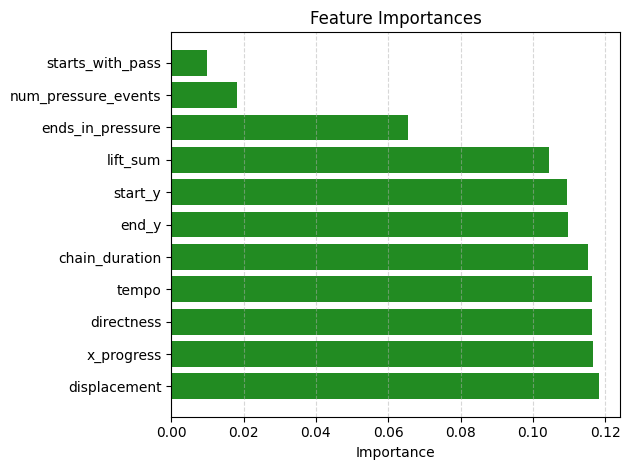

In [239]:
plt.barh(sorted_features['feature'], sorted_features['importance'], color='forestgreen')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [112]:
# lets train a classical model with the features generated + team embeddings

X_train.head()

match_id  player_id  possession  first_event_idx  is_home_team  referee_id  \
0   3753972         12           2               24             0           5   
1   3753972         13           2               27             0           5   
2   3753972         14           2               29             0           5   
3   3753972         19           3               39             0           5   
4   3753972         35           3               77             0           5   

                                      event_sequence  y  start_x  start_y  \
0  [pass, ball_receipt, carry, pass, ball_receipt...  0     28.5     33.9   
1  [pass, ball_receipt, carry, pass, ball_receipt...  0     33.2     60.5   
2  [carry, pass, ball_receipt, carry, pass, ball_...  0     31.0     32.9   
3  [pass, ball_receipt, pass, pressure, ball_rece...  0     15.5      8.8   
4  [pressure, ball_receipt, carry, pass, ball_rec...  0     18.4     39.1   

   end_x  end_y  chain_length  chain_duration     tempo  displacement  \
0   31.9   31.1             7           7.069  0.990239      4.404543   
1   41.2   30.0             7           3.892  1.798561     31.531730   
2   24.1   27.2             7           4.808  1.455907      8.949860   
3   90.6   60.0             7           7.868  0.889680     90.892519   
4    6.4   25.3             7           6.579  1.063991     18.287701   

   directness  x_progress                                 event_sequence_str  \
0    0.629220         3.4  pass ball_receipt carry pass ball_receipt carr...   
1    4.504533         8.0  pass ball_receipt carry pass ball_receipt carr...   
2    1.278551        -6.9  carry pass ball_receipt carry pass ball_receip...   
3   12.984646        75.1  pass ball_receipt pass pressure ball_receipt c...   
4    2.612529       -12.0  pressure ball_receipt carry pass ball_receipt ...   

   sequence_length  starts_with_pass  ends_in_pressure  num_pressure_events  \
0                7                 1                 0                    0   
1                7                 1                 0                    0   
2                7                 0                 0                    0   
3                7                 1                 0                    1   
4                7                 0                 0                    1   

   unique_event_count  lift_max  lift_mean  lift_sum  
0                   3 -0.095413  -0.219899 -1.319396  
1                   3 -0.095413  -0.219899 -1.319396  
2                   3  0.106742  -0.186207 -1.117240  
3                   4  1.244512   0.117892  0.707353  
4                   5  0.171035  -0.080848 -0.485088